In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
import os
os.chdir('..')

In [5]:
import warnings
warnings.filterwarnings('ignore', '', UserWarning)

In [7]:
import torch
import torchvision

torch.manual_seed(1)
torch.cuda.manual_seed(1)
device = 'cuda'

In [7]:
dataset_params = {
    'dataset': 'dsprites',
    'batch_size': 32,
    'cuda': True,
    'root': 'data'
}

In [8]:
from src.utils import get_datasets
train_loader, test_loader, (width, height, channels) = get_datasets(
    **dataset_params)

Loading dsprites dataset...
Done!



In [41]:
model_params = {
    'dataset': 'dSprites',
    'width': width,
    'height': height,
    'channels': channels,
    'kernel_szs': '32,32,64,64',
    'hidden_sz': 256,
    'latent_sz': 64,
    'learning_rate': 1e-3,
    'alpha': 1e-3,
    'device': 'cuda',
    'log_interval': 4000,
    'normalize': False,
    'flatten': False
}

In [42]:
from src.models.conv_vsc import ConvolutionalVariationalSparseCoding
convvsc = ConvolutionalVariationalSparseCoding(**model_params)

In [43]:
training_params = {
    'train_loader': train_loader,
    'test_loader': test_loader,
    'epochs': 3,
    'report_interval': 100,
    'sample_sz': 64,
    'reload_model': False
}

In [44]:
%%time
convvsc.run_training(**training_params)

Training ConvVSC model...
Train Epoch: 1 [0/600000 (0%)]	Loss: 3185.704834
Train Epoch: 1 [128000/600000 (21%)]	Loss: 69.142921
Train Epoch: 1 [256000/600000 (43%)]	Loss: 68.080284
Train Epoch: 1 [384000/600000 (64%)]	Loss: 48.599255
Train Epoch: 1 [512000/600000 (85%)]	Loss: 47.684532
====> Epoch: 1 Average loss: 59.9539
====> Test set loss: 26.8174 - VLB-ConvVSC : 858.1567
Train Epoch: 2 [0/600000 (0%)]	Loss: 27.111755
Train Epoch: 2 [128000/600000 (21%)]	Loss: 19.770761
Train Epoch: 2 [256000/600000 (43%)]	Loss: 20.296257
Train Epoch: 2 [384000/600000 (64%)]	Loss: 20.240282
Train Epoch: 2 [512000/600000 (85%)]	Loss: 19.969736
====> Epoch: 2 Average loss: 20.4375
====> Test set loss: 19.8552 - VLB-ConvVSC : 635.3660
Train Epoch: 3 [0/600000 (0%)]	Loss: 19.989647
Train Epoch: 3 [128000/600000 (21%)]	Loss: 19.745621
Train Epoch: 3 [256000/600000 (43%)]	Loss: 20.036983
Train Epoch: 3 [384000/600000 (64%)]	Loss: 19.600992
Train Epoch: 3 [512000/600000 (85%)]	Loss: 19.846443
====> Epoch: 

In [34]:
images, _ = iter(test_loader).next()

In [68]:
import numpy as np
import matplotlib.pyplot as plt

def plot_image(img, ax, title):
    ax.imshow(np.transpose(img, (1,2,0)) * 255, interpolation='nearest')
    ax.set_title(title, fontsize=20)
    
def to_numpy(image, vsc):
    return torchvision.utils.make_grid(
        image.view(1, vsc.channels, vsc.height, vsc.width)
    ).cpu().detach().numpy()
    
def plot_encoding(image, vsc, latent_sz, alpha, width=1/7):
    image = vsc.transform(image).to(vsc.device)
    decoded, mu, logvar, logspike = vsc.model.forward(image)
    z = vsc.model.reparameterize(mu, logvar, logspike)
    img = vsc.inverse_transform(vsc.model.decode(z))
    z = z.cpu().detach().numpy()[0]
    
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(21,7))
    
    plot_image(to_numpy(image, vsc), ax0, 'Input Image')
    
    ax1.bar(np.arange(latent_sz), height=z, width=width, align='center')
    ax1.scatter(np.arange(latent_sz), z, color='blue')
    ax1.set_title(r"Latent Dimension %d - $\alpha$ = %.2f " % \
                  (latent_sz, alpha), fontsize=20)
    
    plot_image(to_numpy(img, vsc), ax2, 'Decoded Image')
    plt.subplots_adjust(hspace=0.5)

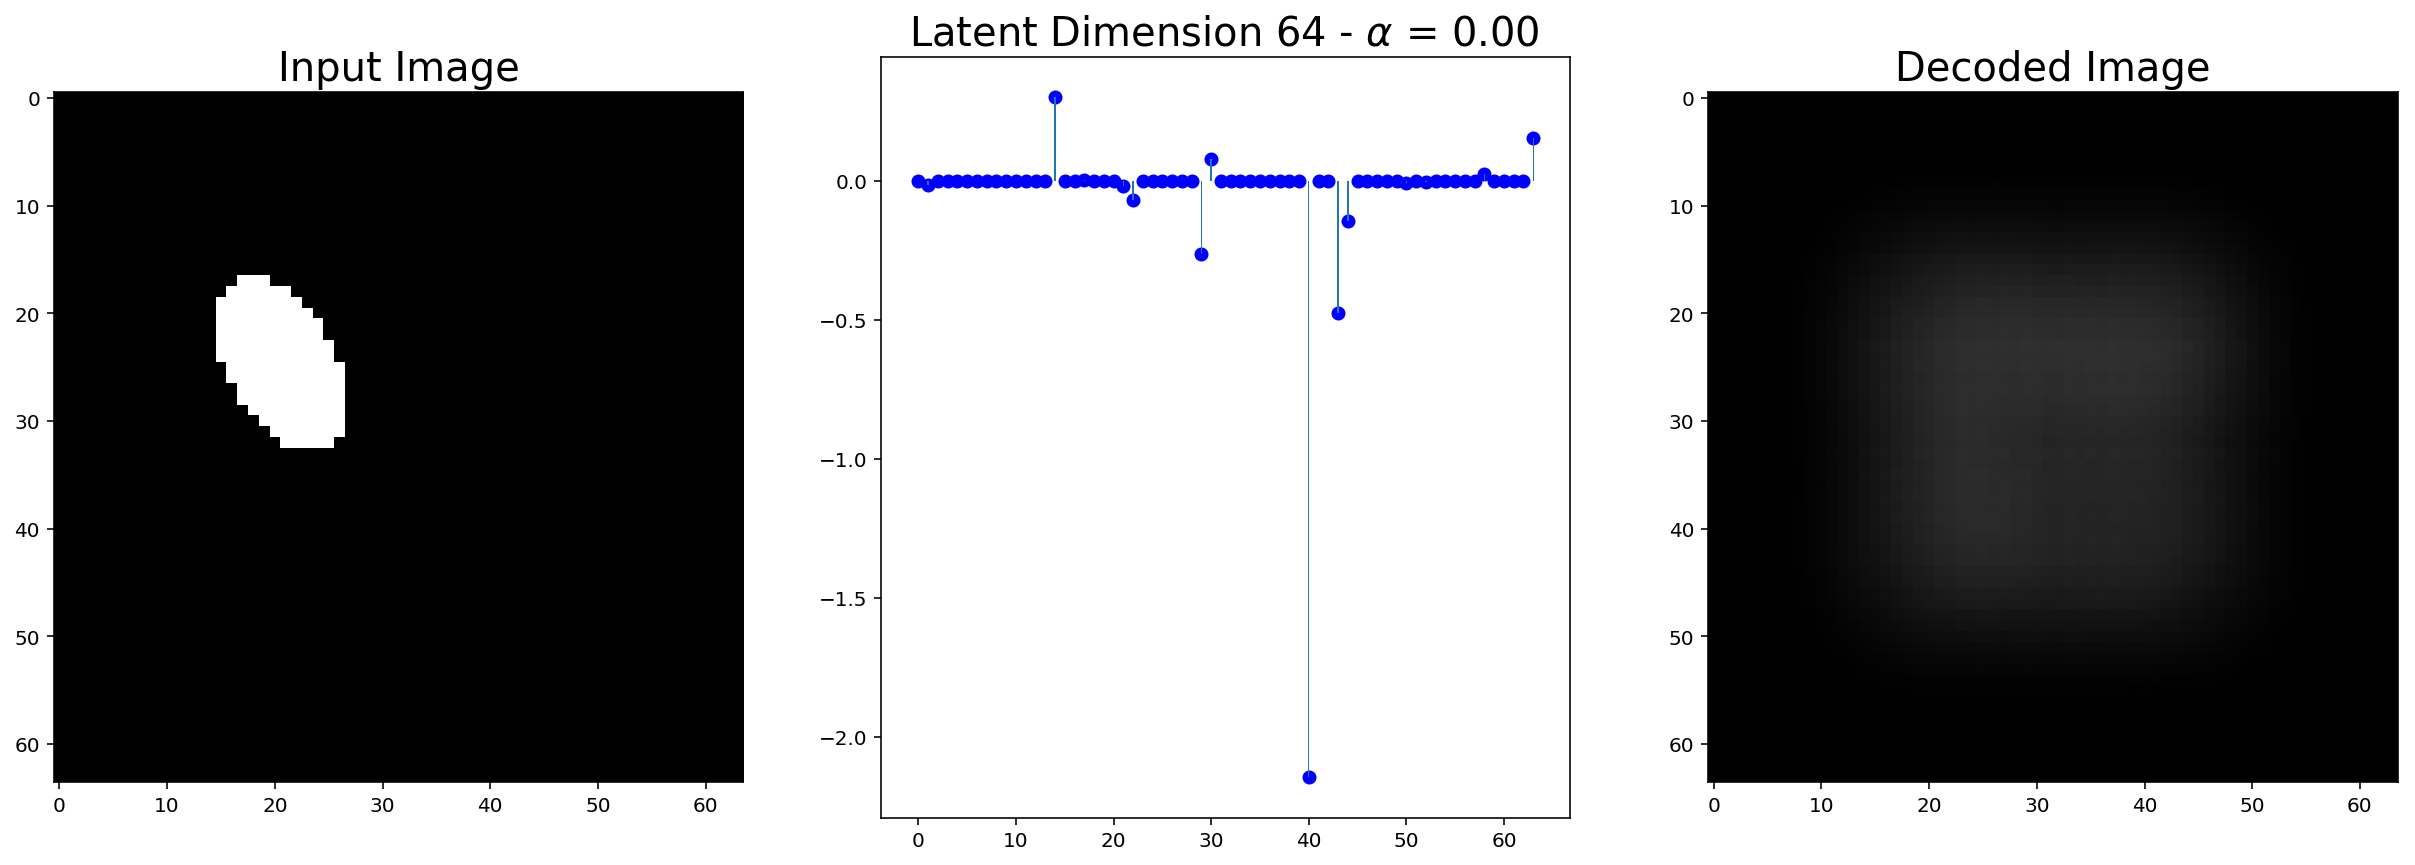

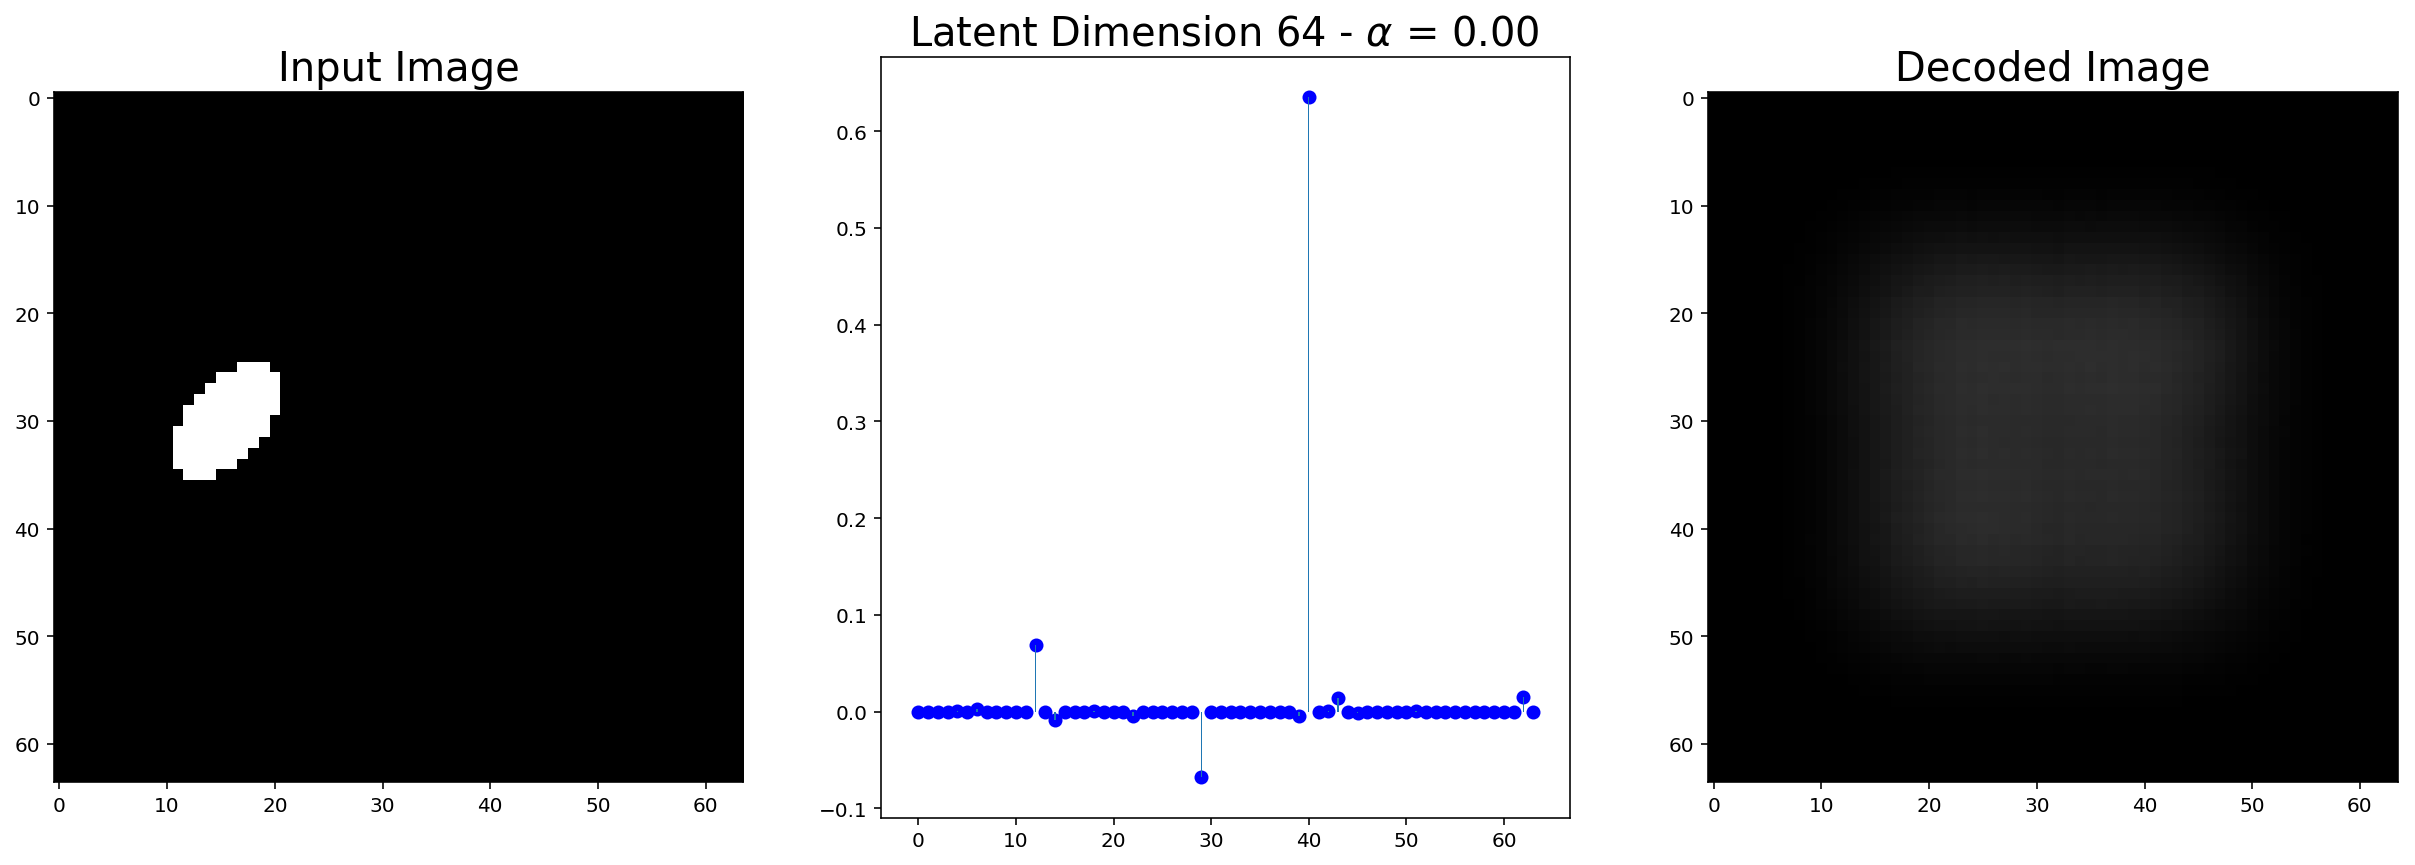

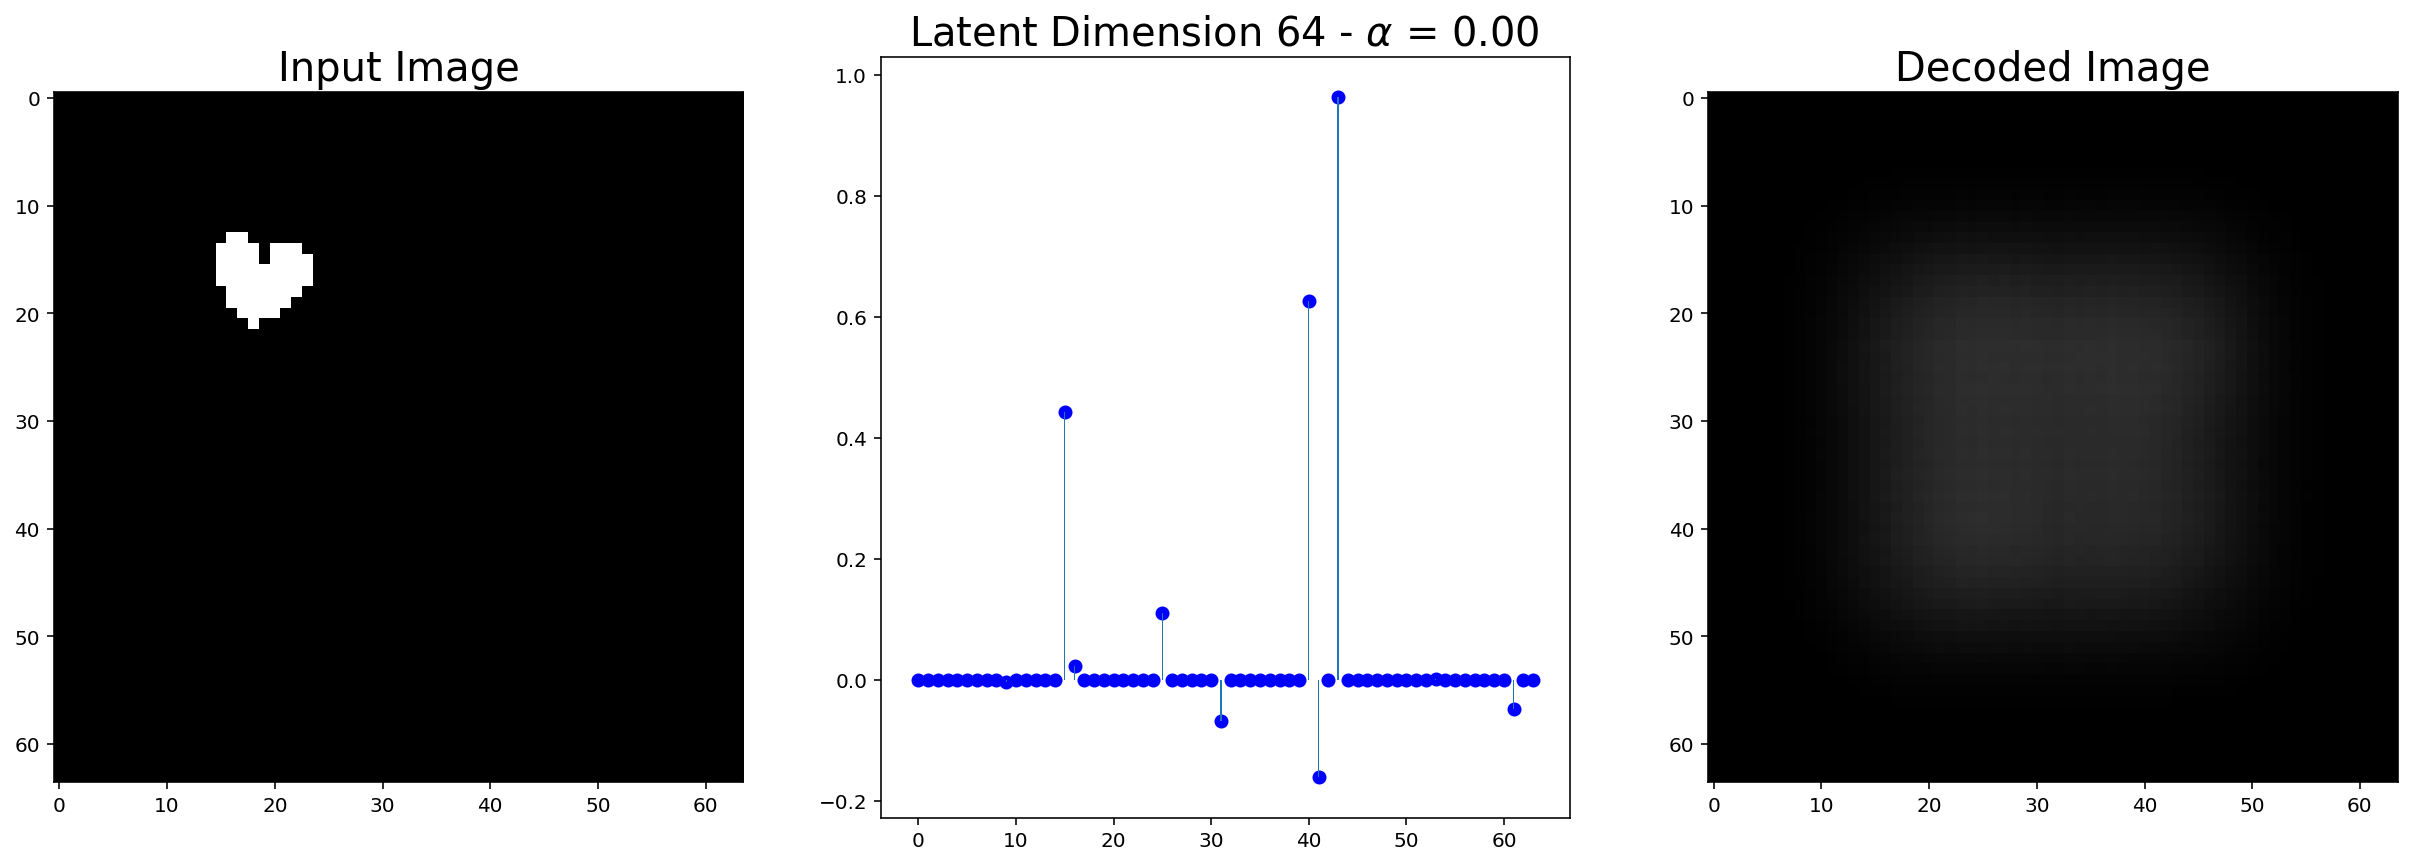

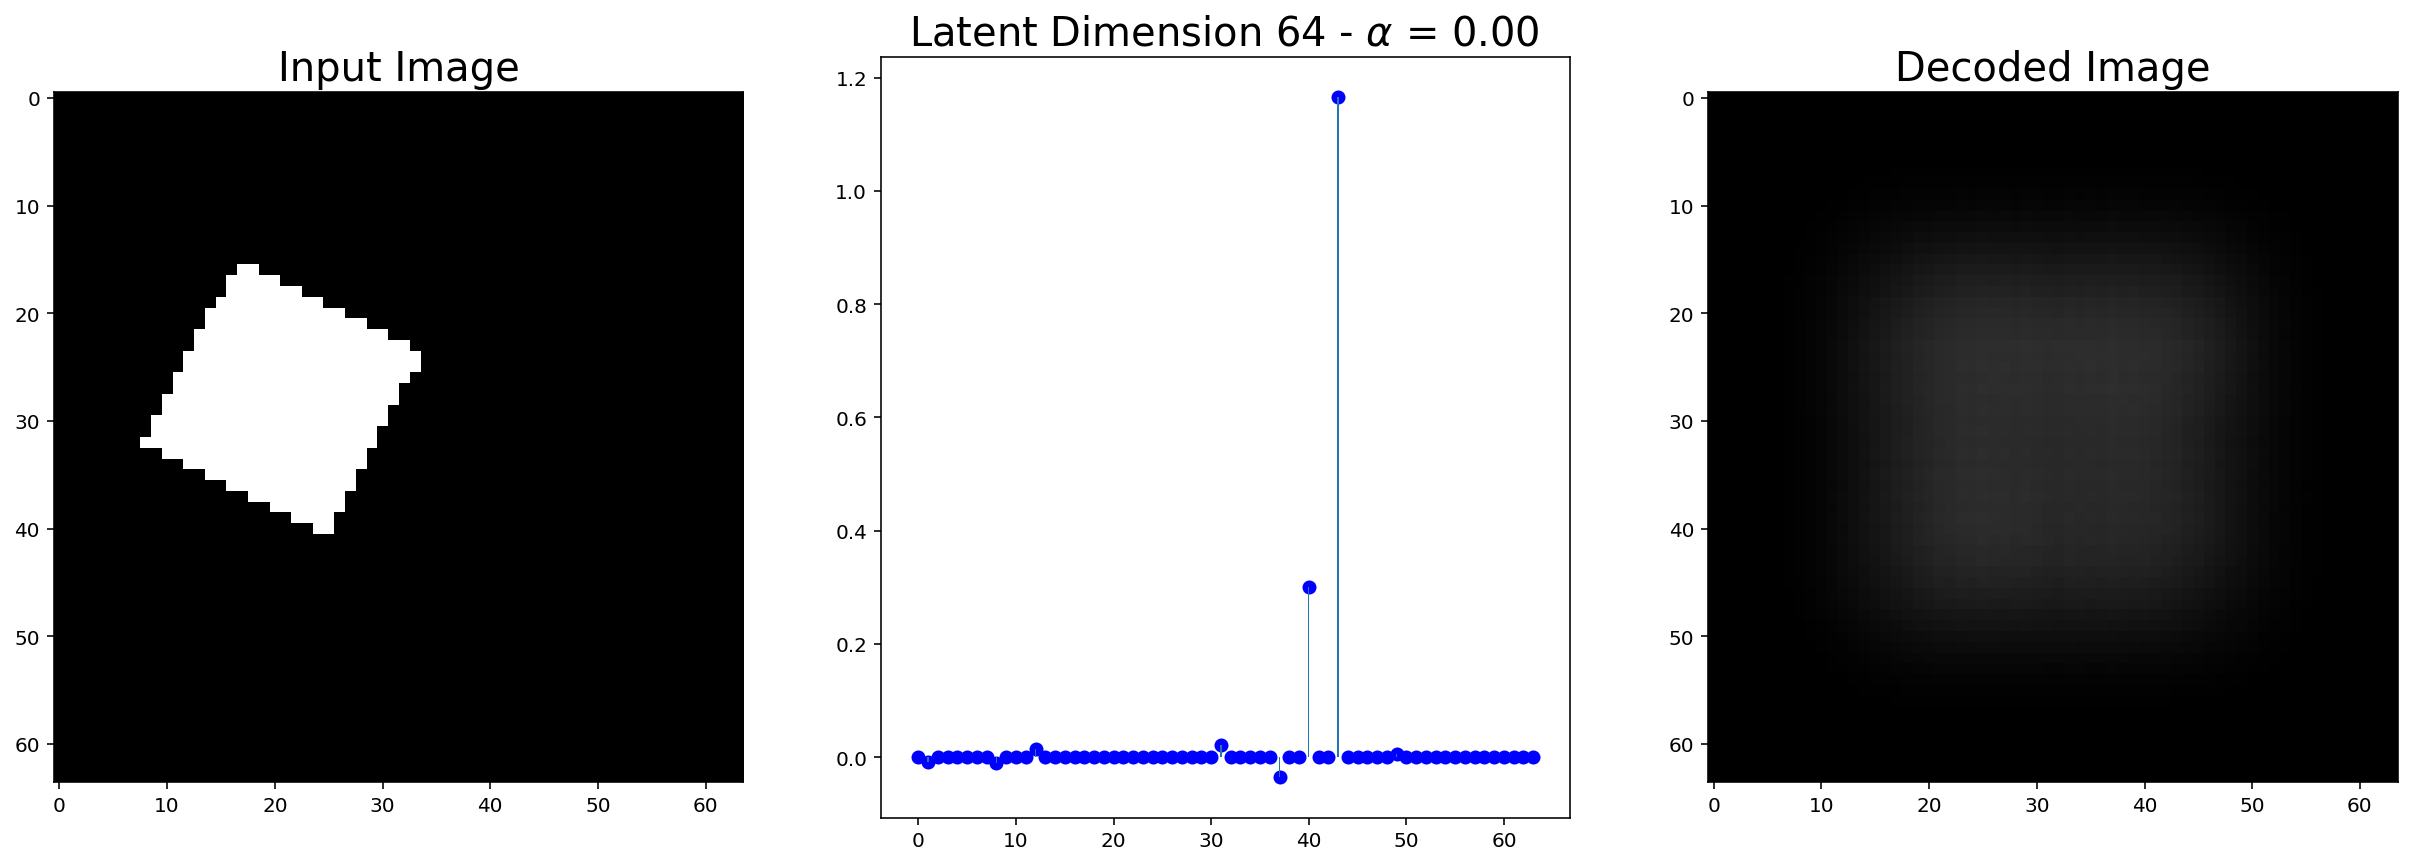

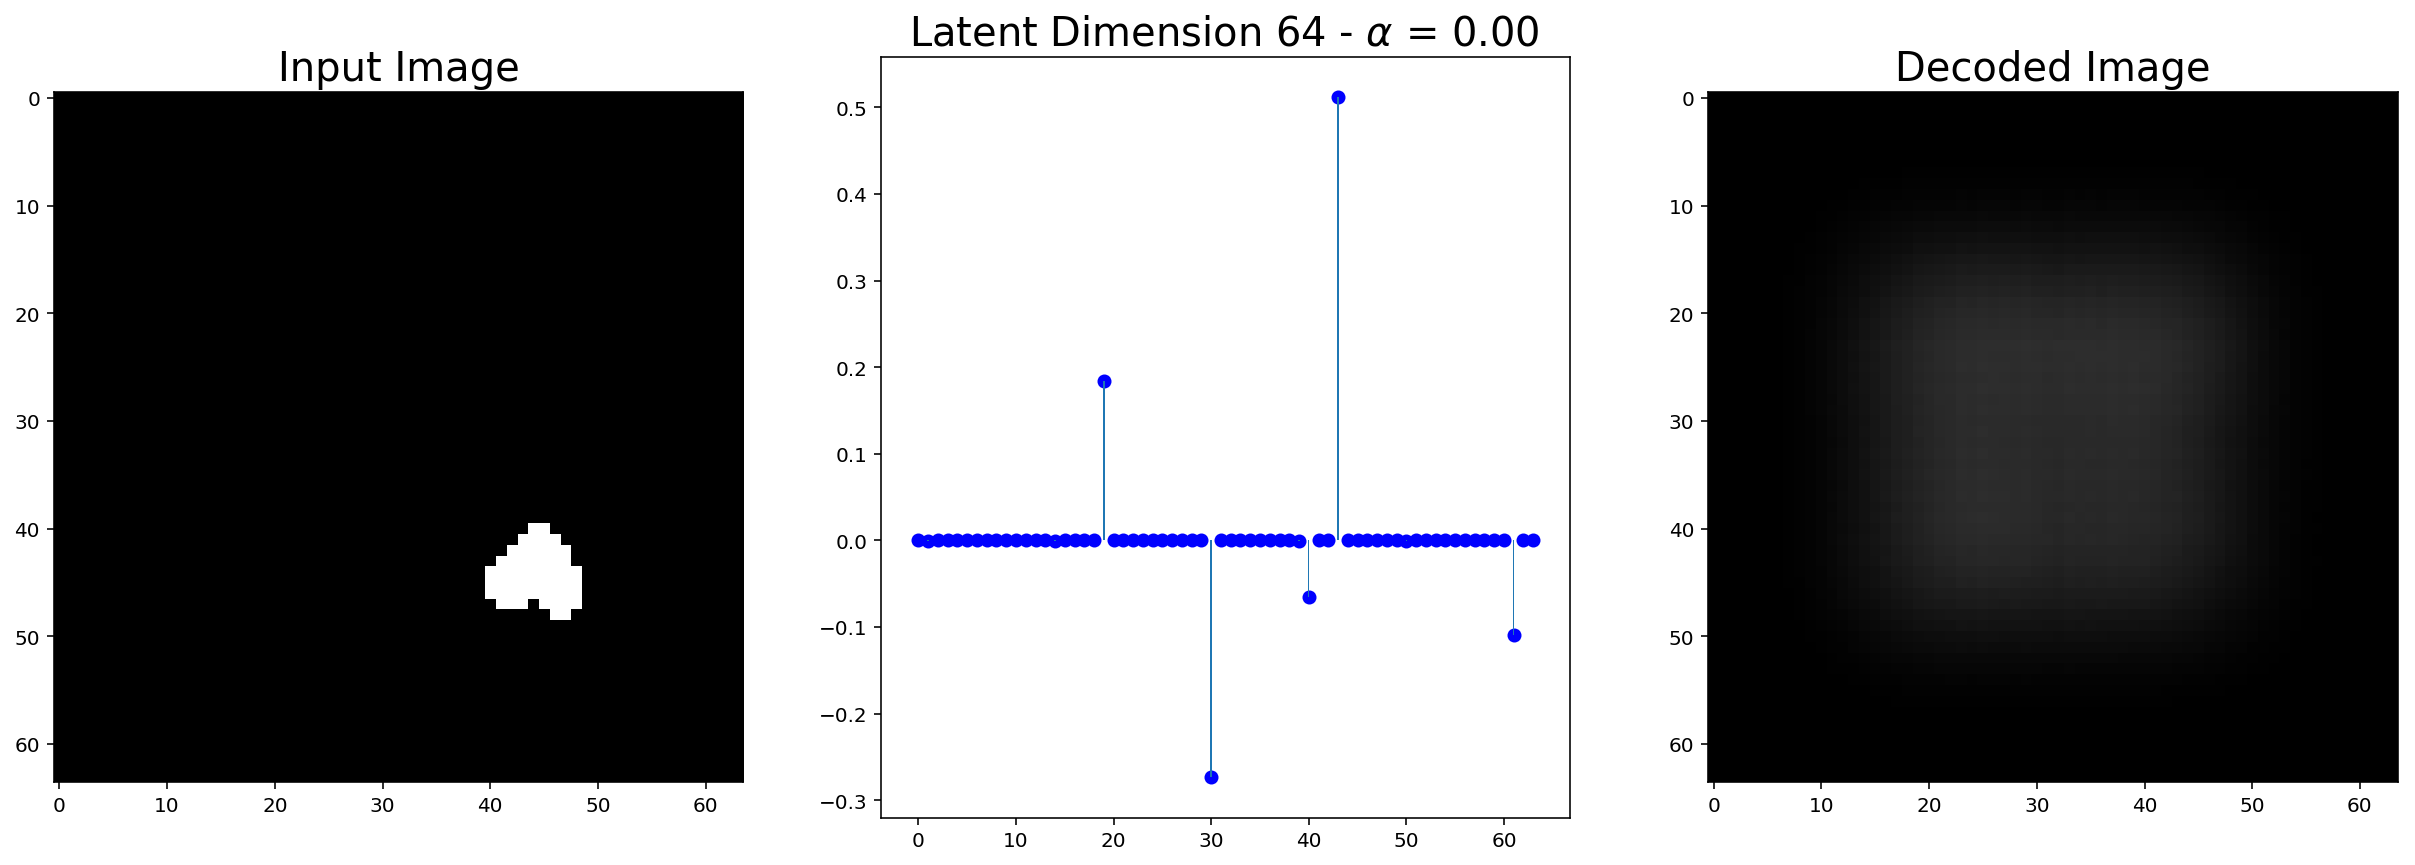

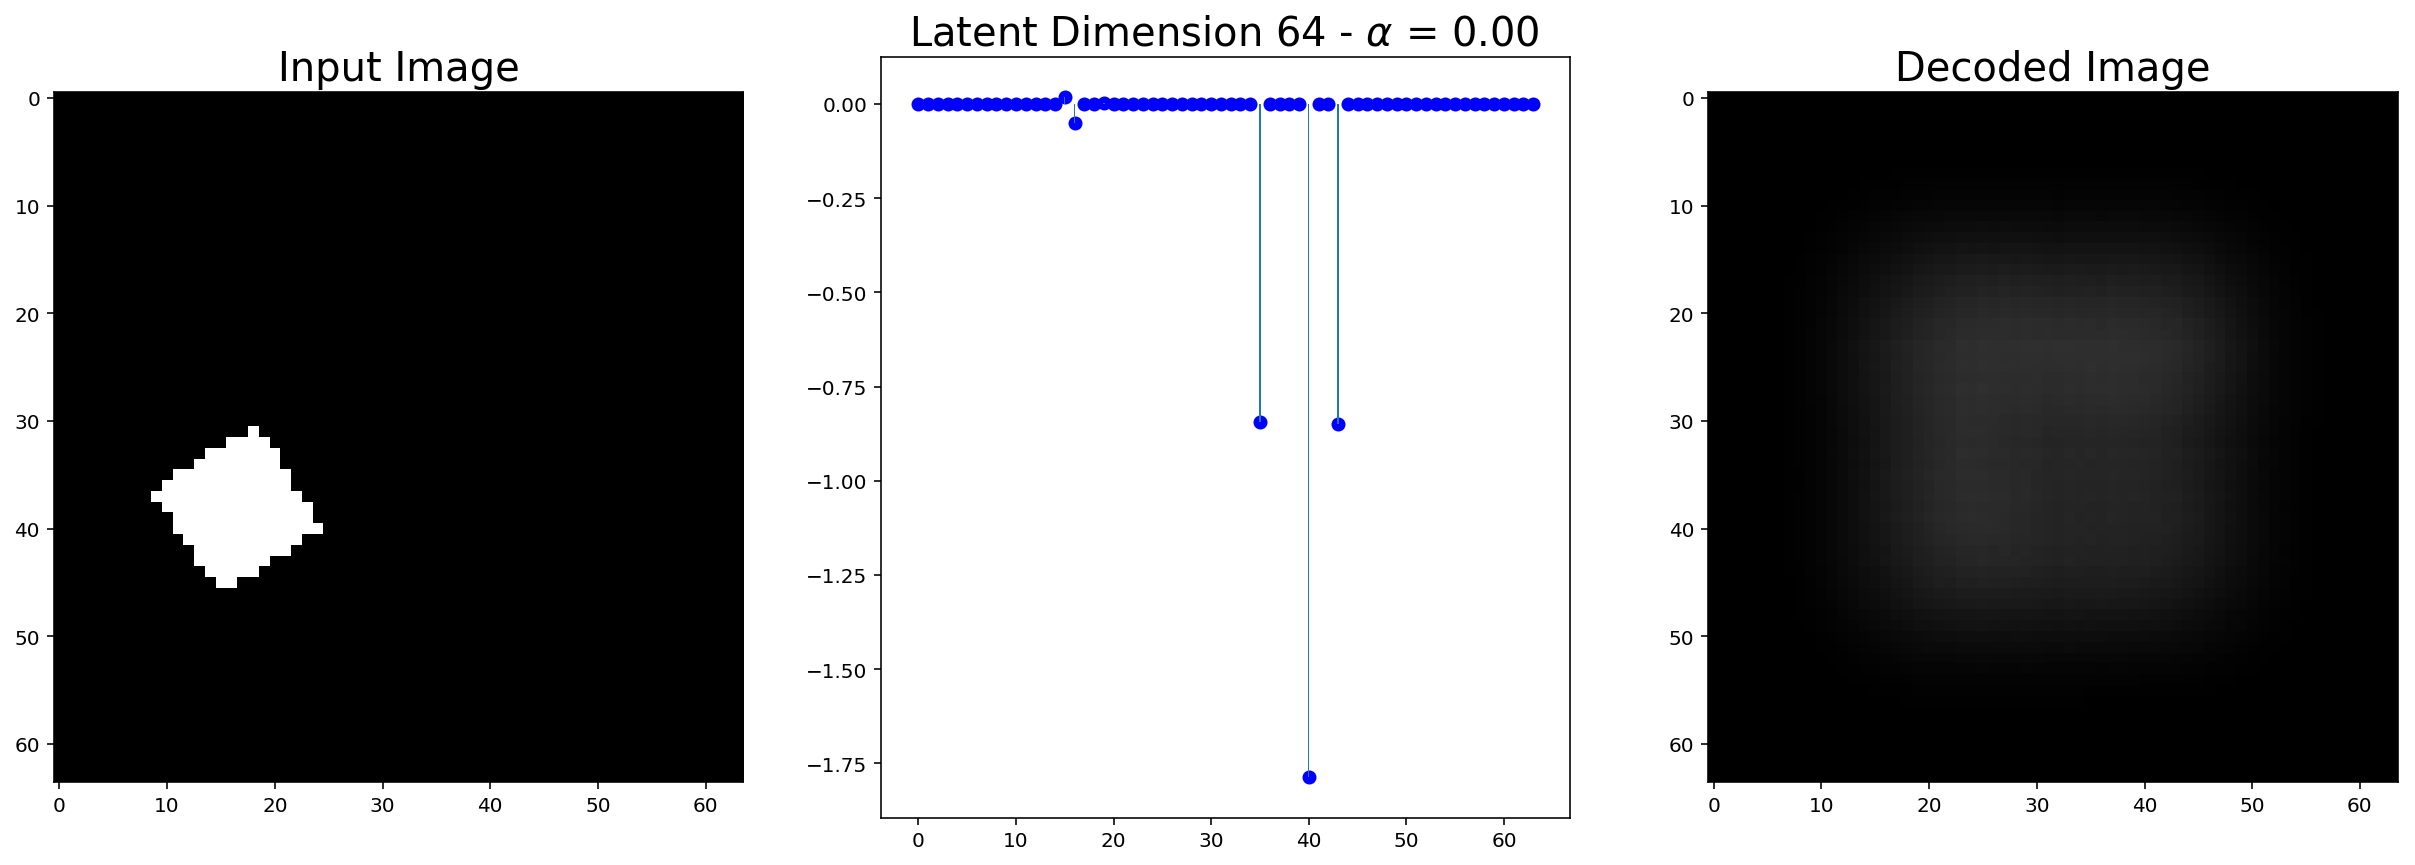

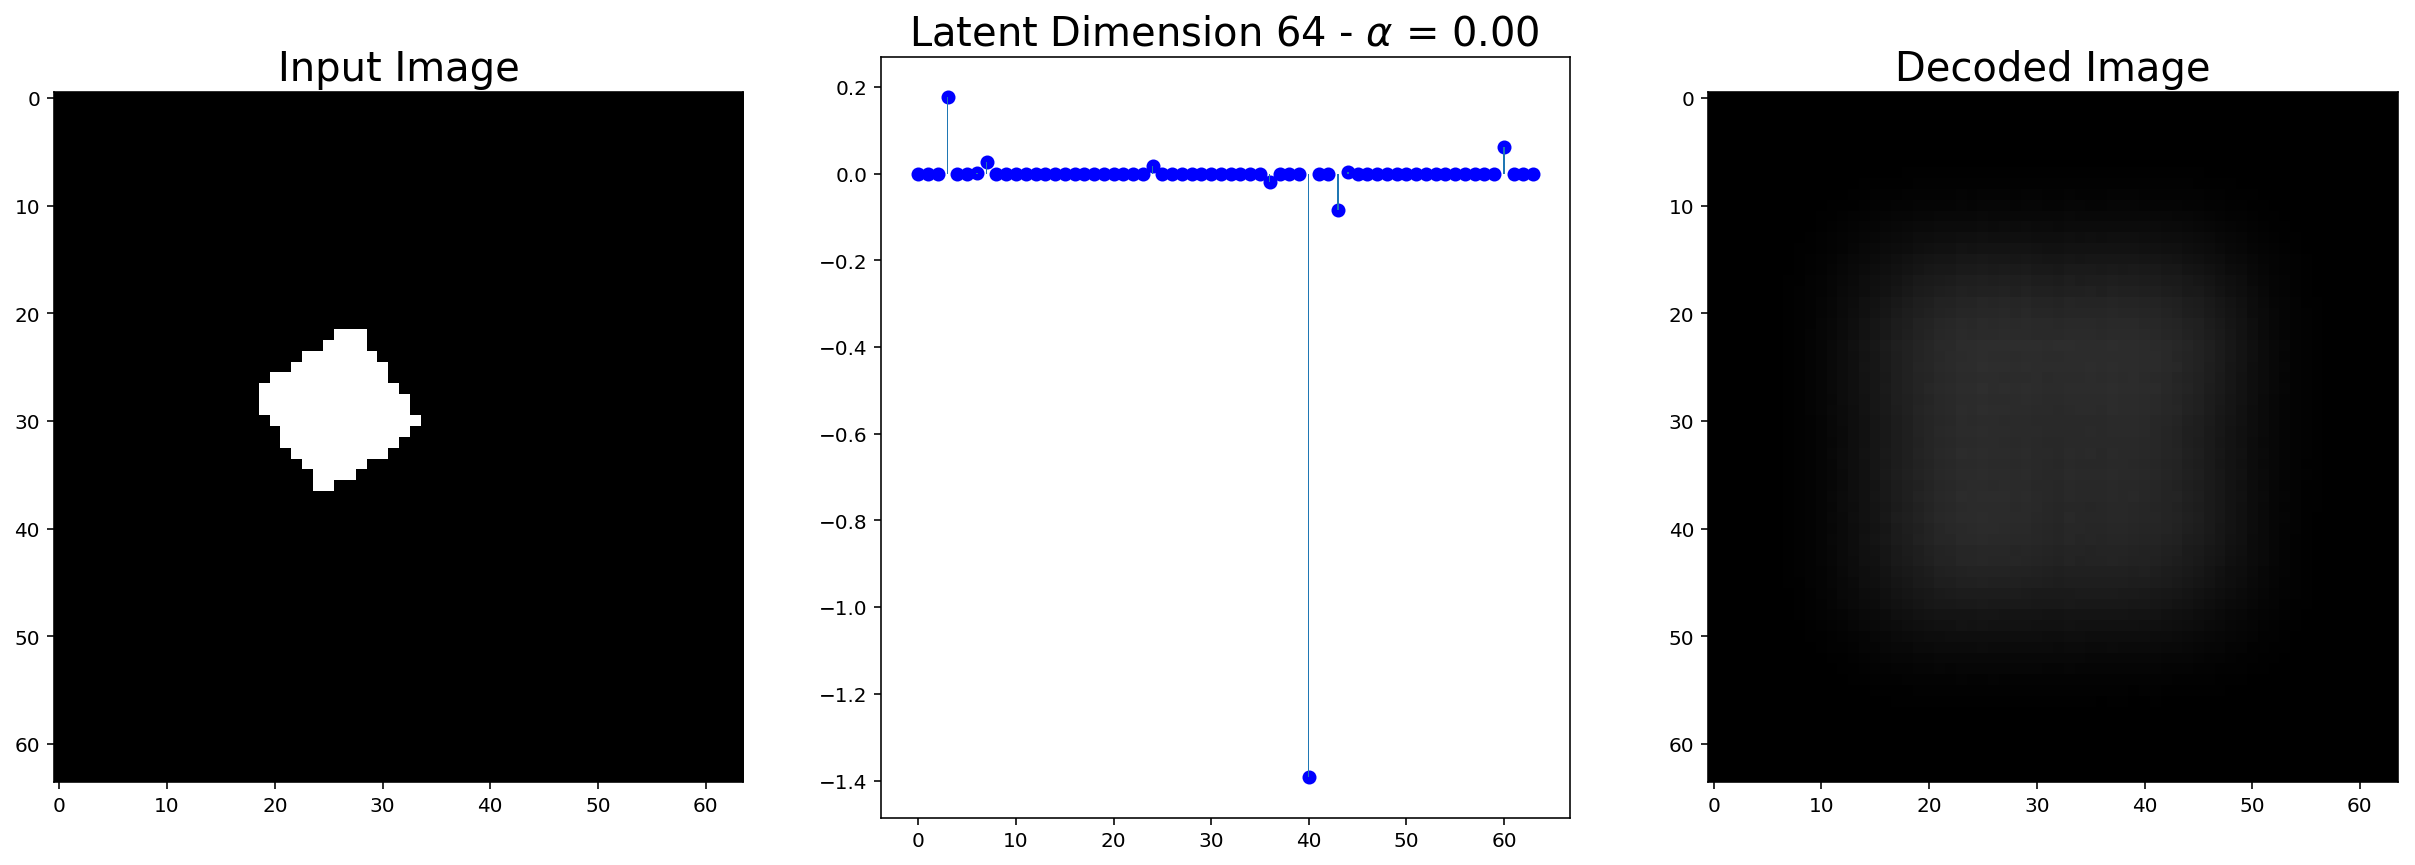

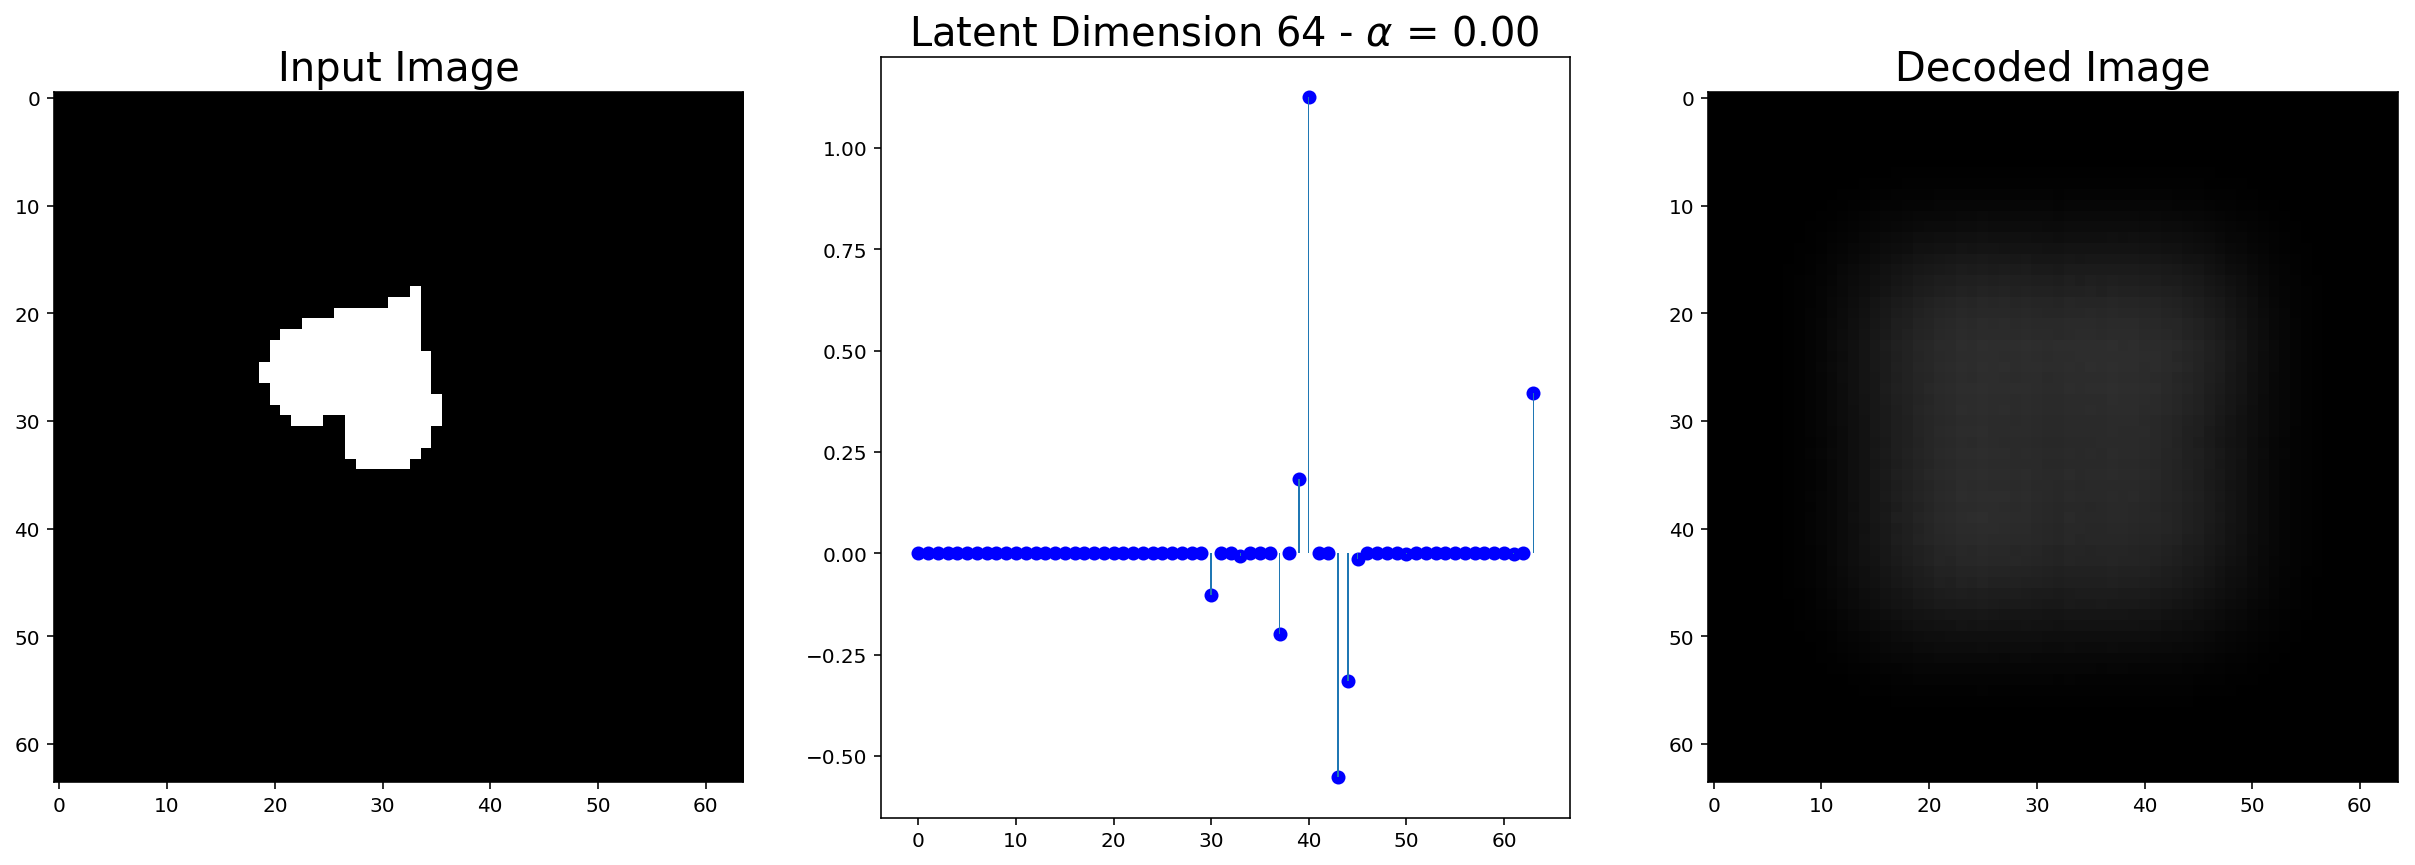

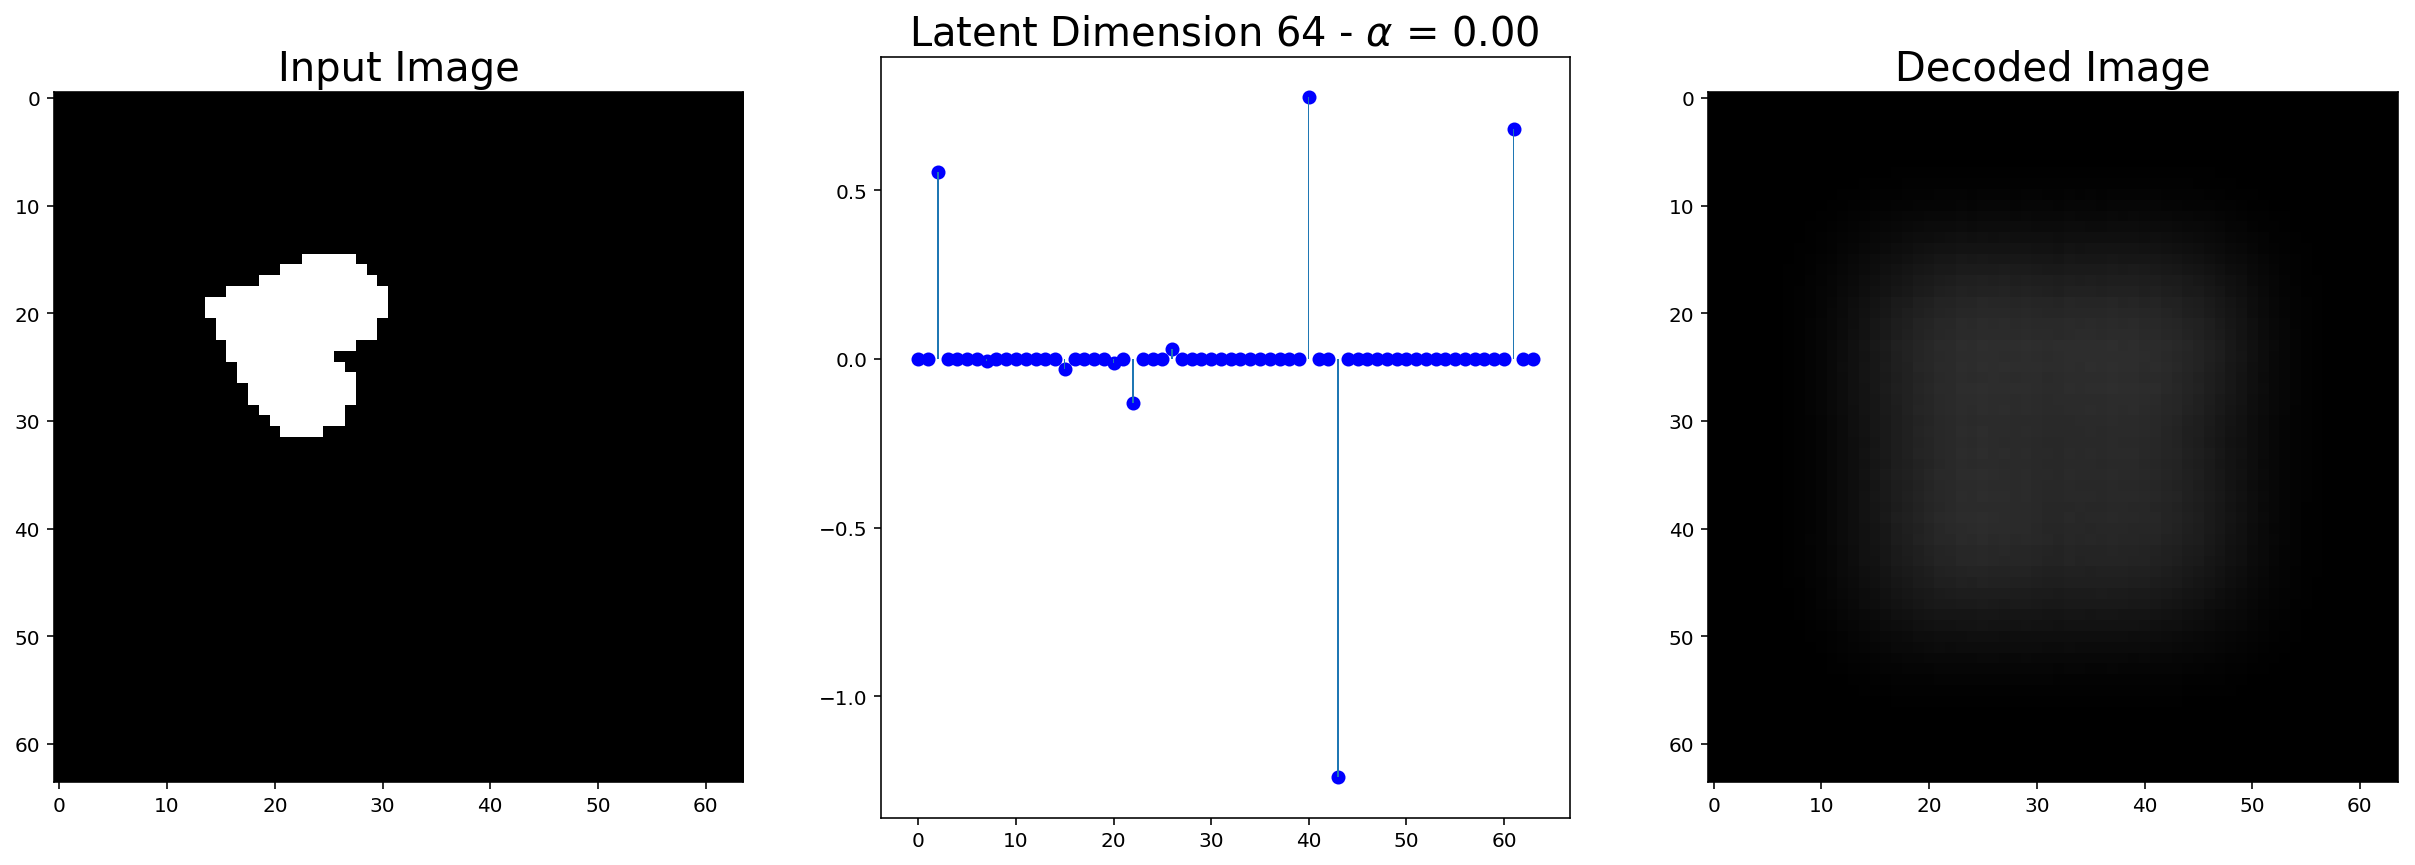

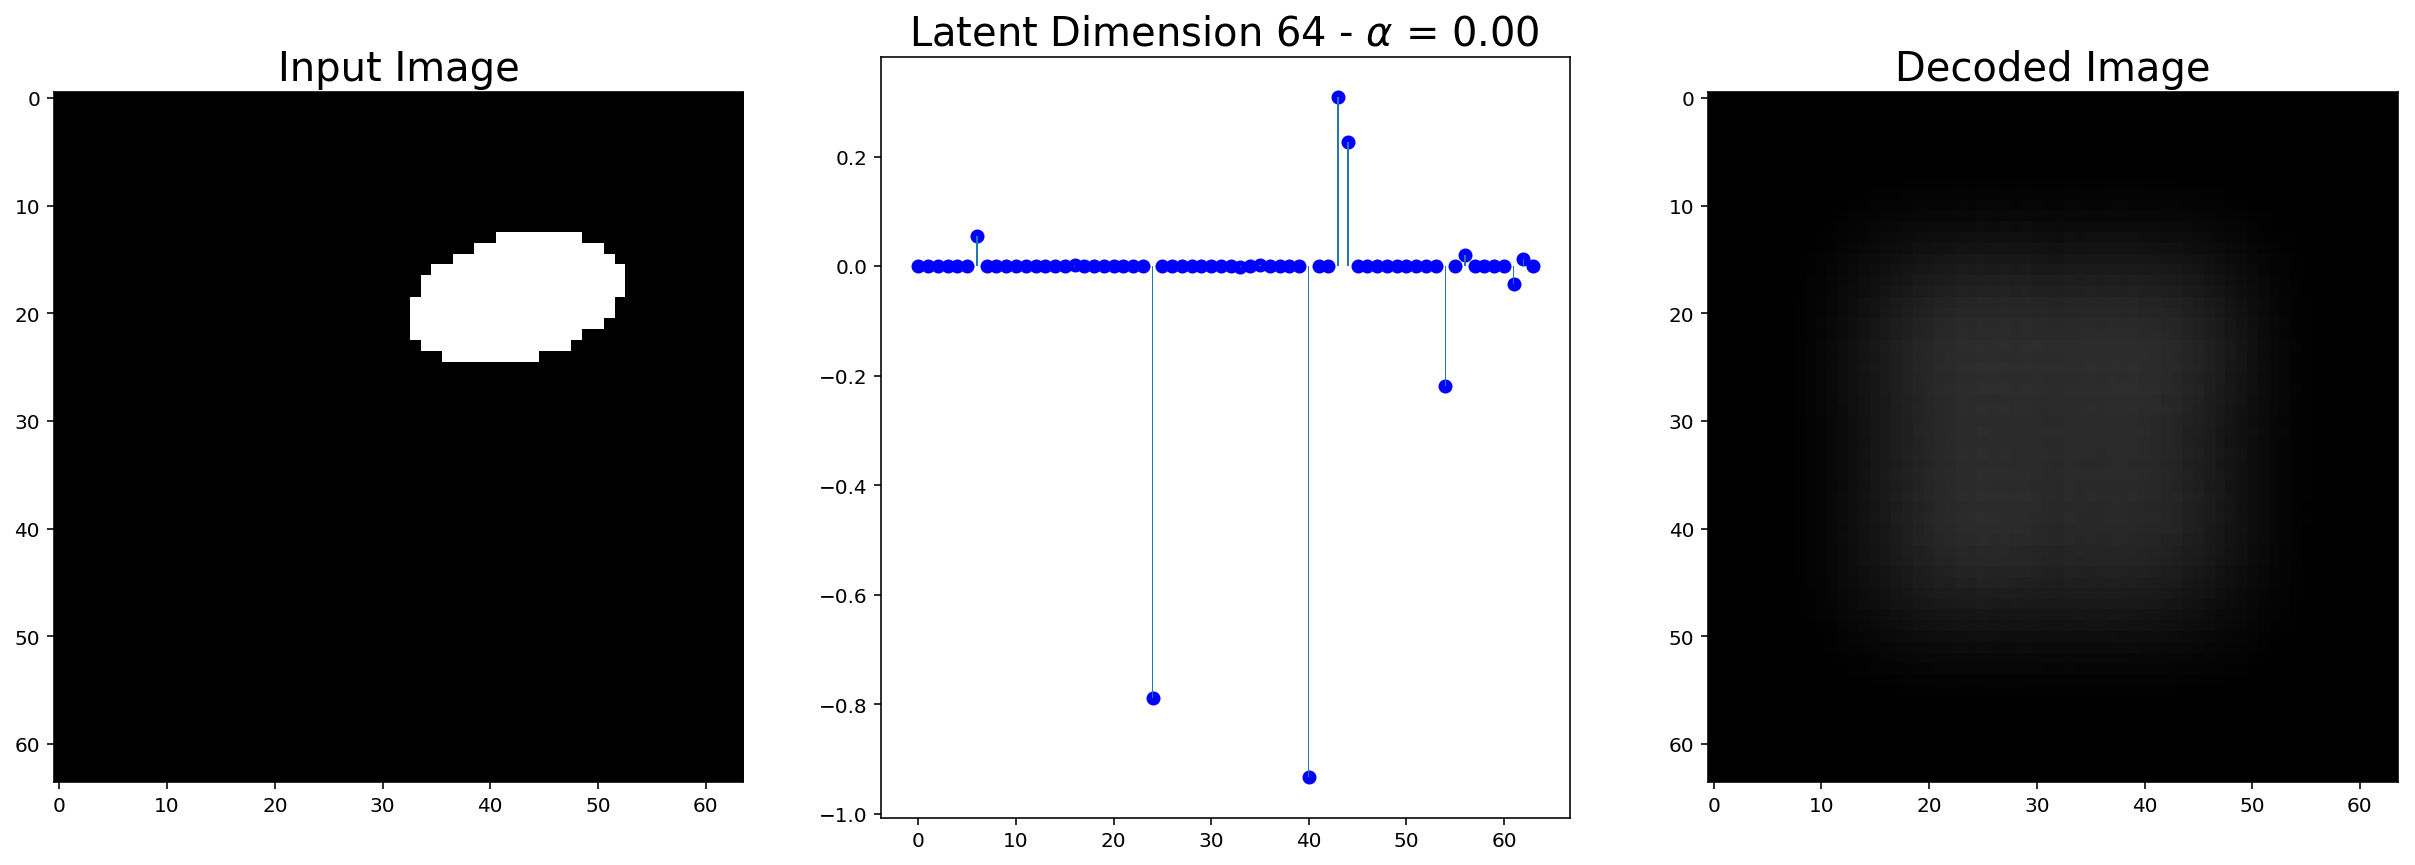

In [53]:
for i in range(10):
    plot_encoding(images[-i][None,:], convvsc, model_params['latent_sz'], 
                  model_params['alpha'])

## CelebA

In [8]:
dataset_params = {
    'dataset': 'celeba',
    'batch_size': 32,
    'cuda': True,
    'root': 'data'
}

from src.utils import get_datasets
train_loader, test_loader, (width, height, channels) = get_datasets(
    **dataset_params)

Loading celeba dataset...
Done!



In [9]:
model_params = {
    'dataset': 'celeba',
    'width': width,
    'height': height,
    'channels': channels,
    'kernel_szs': '32,32,64,64',
    'hidden_sz': 256,
    'latent_sz': 800,
    'learning_rate': 1e-3,
    'alpha': 1e-2,
    'device': 'cuda',
    'log_interval': 4000,
    'normalize': False,
    'flatten': False
}

from src.models.conv_vsc import ConvolutionalVariationalSparseCoding
convvsc = ConvolutionalVariationalSparseCoding(**model_params)

In [11]:
convvsc.model.load_state_dict(
    torch.load('results/checkpoints/ConvVSC_celeba_1_6_800_0-001_6.pth'))

In [65]:
%%time
training_params = {
    'train_loader': train_loader,
    'test_loader': test_loader,
    'epochs': 2,
    'report_interval': 1,
    'sample_sz': 64,
    'reload_model': False,
    'checkpoints_path': 'results/checkpoints',
    'logs_path': 'results/logs',
    'images_path': 'results/images'
}

convvsc.run_training(**training_params)

Training ConvVSC model...
Train Epoch: 1 [0/100000 (0%)]	Loss: 1745.016479
====> Epoch: 1 Average loss: 1754.2060
====> Test set loss: 1747.5218 - VLB-ConvVSC : 55920.6974
Train Epoch: 2 [0/100000 (0%)]	Loss: 1739.226929
====> Epoch: 2 Average loss: 1742.5717
====> Test set loss: 1740.2061 - VLB-ConvVSC : 55686.5944
CPU times: user 1min 37s, sys: 5.05 s, total: 1min 43s
Wall time: 1min 51s


In [66]:
%%time
training_params = {
    'train_loader': train_loader,
    'test_loader': test_loader,
    'epochs': 4,
    'report_interval': 1,
    'sample_sz': 64,
    'reload_model': False,
    'checkpoints_path': 'results/checkpoints',
    'logs_path': 'results/logs',
    'images_path': 'results/images'
}

convvsc.run_training(**training_params)

Training ConvVSC model...
Train Epoch: 1 [0/100000 (0%)]	Loss: 1749.558960
====> Epoch: 1 Average loss: 1735.9964
====> Test set loss: 1730.3758 - VLB-ConvVSC : 55372.0250
Train Epoch: 2 [0/100000 (0%)]	Loss: 1765.888916
====> Epoch: 2 Average loss: 1729.0945
====> Test set loss: 1724.5293 - VLB-ConvVSC : 55184.9376
Train Epoch: 3 [0/100000 (0%)]	Loss: 1744.111328
====> Epoch: 3 Average loss: 1721.5704
====> Test set loss: 1721.9489 - VLB-ConvVSC : 55102.3663
Train Epoch: 4 [0/100000 (0%)]	Loss: 1722.743164
====> Epoch: 4 Average loss: 1719.7277
====> Test set loss: 1720.1695 - VLB-ConvVSC : 55045.4243
CPU times: user 3min 15s, sys: 10.4 s, total: 3min 25s
Wall time: 3min 41s


In [67]:
%%time
training_params = {
    'train_loader': train_loader,
    'test_loader': test_loader,
    'epochs': 6,
    'report_interval': 2,
    'sample_sz': 64,
    'reload_model': False,
    'checkpoints_path': 'results/checkpoints',
    'logs_path': 'results/logs',
    'images_path': 'results/images'
}

convvsc.run_training(**training_params)

Training ConvVSC model...
Train Epoch: 1 [0/100000 (0%)]	Loss: 1717.718140
====> Epoch: 1 Average loss: 1718.2872
====> Test set loss: 1716.9521 - VLB-ConvVSC : 54942.4674
Train Epoch: 2 [0/100000 (0%)]	Loss: 1703.480591
====> Epoch: 2 Average loss: 1715.7344
====> Test set loss: 1714.8871 - VLB-ConvVSC : 54876.3876
Train Epoch: 3 [0/100000 (0%)]	Loss: 1681.187500
====> Epoch: 3 Average loss: 1714.6681
====> Test set loss: 1714.4732 - VLB-ConvVSC : 54863.1431
Train Epoch: 4 [0/100000 (0%)]	Loss: 1673.280273
====> Epoch: 4 Average loss: 1713.8572
====> Test set loss: 1714.0858 - VLB-ConvVSC : 54850.7445
Train Epoch: 5 [0/100000 (0%)]	Loss: 1735.761841
====> Epoch: 5 Average loss: 1713.4727
====> Test set loss: 1714.2975 - VLB-ConvVSC : 54857.5200
Train Epoch: 6 [0/100000 (0%)]	Loss: 1716.776367
====> Epoch: 6 Average loss: 1712.9672
====> Test set loss: 1718.9560 - VLB-ConvVSC : 55006.5929
CPU times: user 4min 53s, sys: 15.3 s, total: 5min 8s
Wall time: 5min 33s


In [12]:
import numpy as np
import matplotlib.pyplot as plt

def plot_image(img, ax, title):
    ax.imshow(np.transpose(img, (1,2,0)), interpolation='nearest')
    ax.set_title(title, fontsize=20)
    
def to_numpy(image, vsc):
    return torchvision.utils.make_grid(
        image.view(1, vsc.channels, vsc.height, vsc.width)
    ).cpu().detach().numpy()
    
def plot_encoding(image, vsc, latent_sz, alpha, width=1/7):
    image = vsc.transform(image).to(vsc.device)
    decoded, mu, logvar, logspike = vsc.model.forward(image)
    z = vsc.model.reparameterize(mu, logvar, logspike)
    img = vsc.inverse_transform(vsc.model.decode(z))
    z = z.cpu().detach().numpy()[0]
    
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(21,7))
    
    plot_image(to_numpy(image, vsc), ax0, 'Input Image')
    
    ax1.bar(np.arange(latent_sz), height=z, width=width, align='center')
    ax1.scatter(np.arange(latent_sz), z, color='blue')
    ax1.set_title(r"Latent Dimension %d - $\alpha$ = %.2f " % \
                  (latent_sz, alpha), fontsize=20)
    
    plot_image(to_numpy(img, vsc), ax2, 'Decoded Image')
    plt.subplots_adjust(hspace=0.5)

In [14]:
images, _ = iter(test_loader).next()

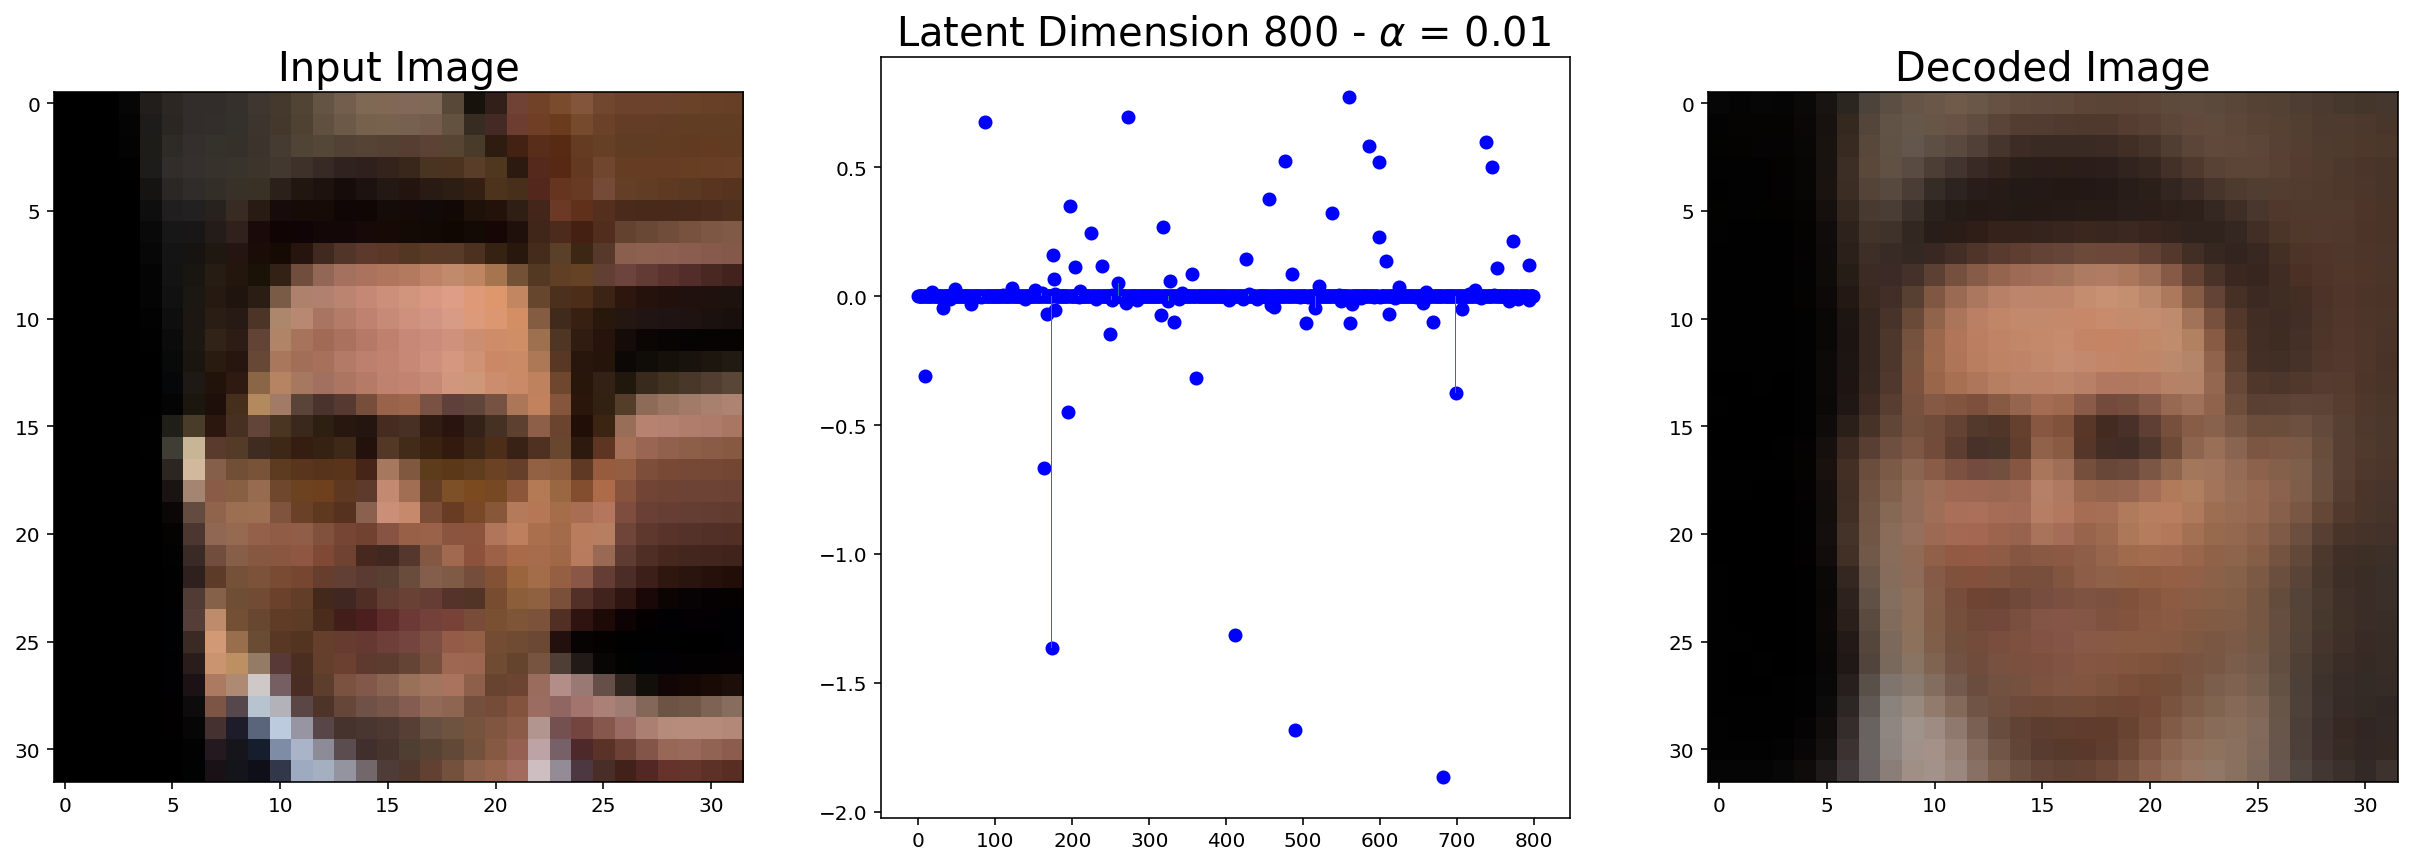

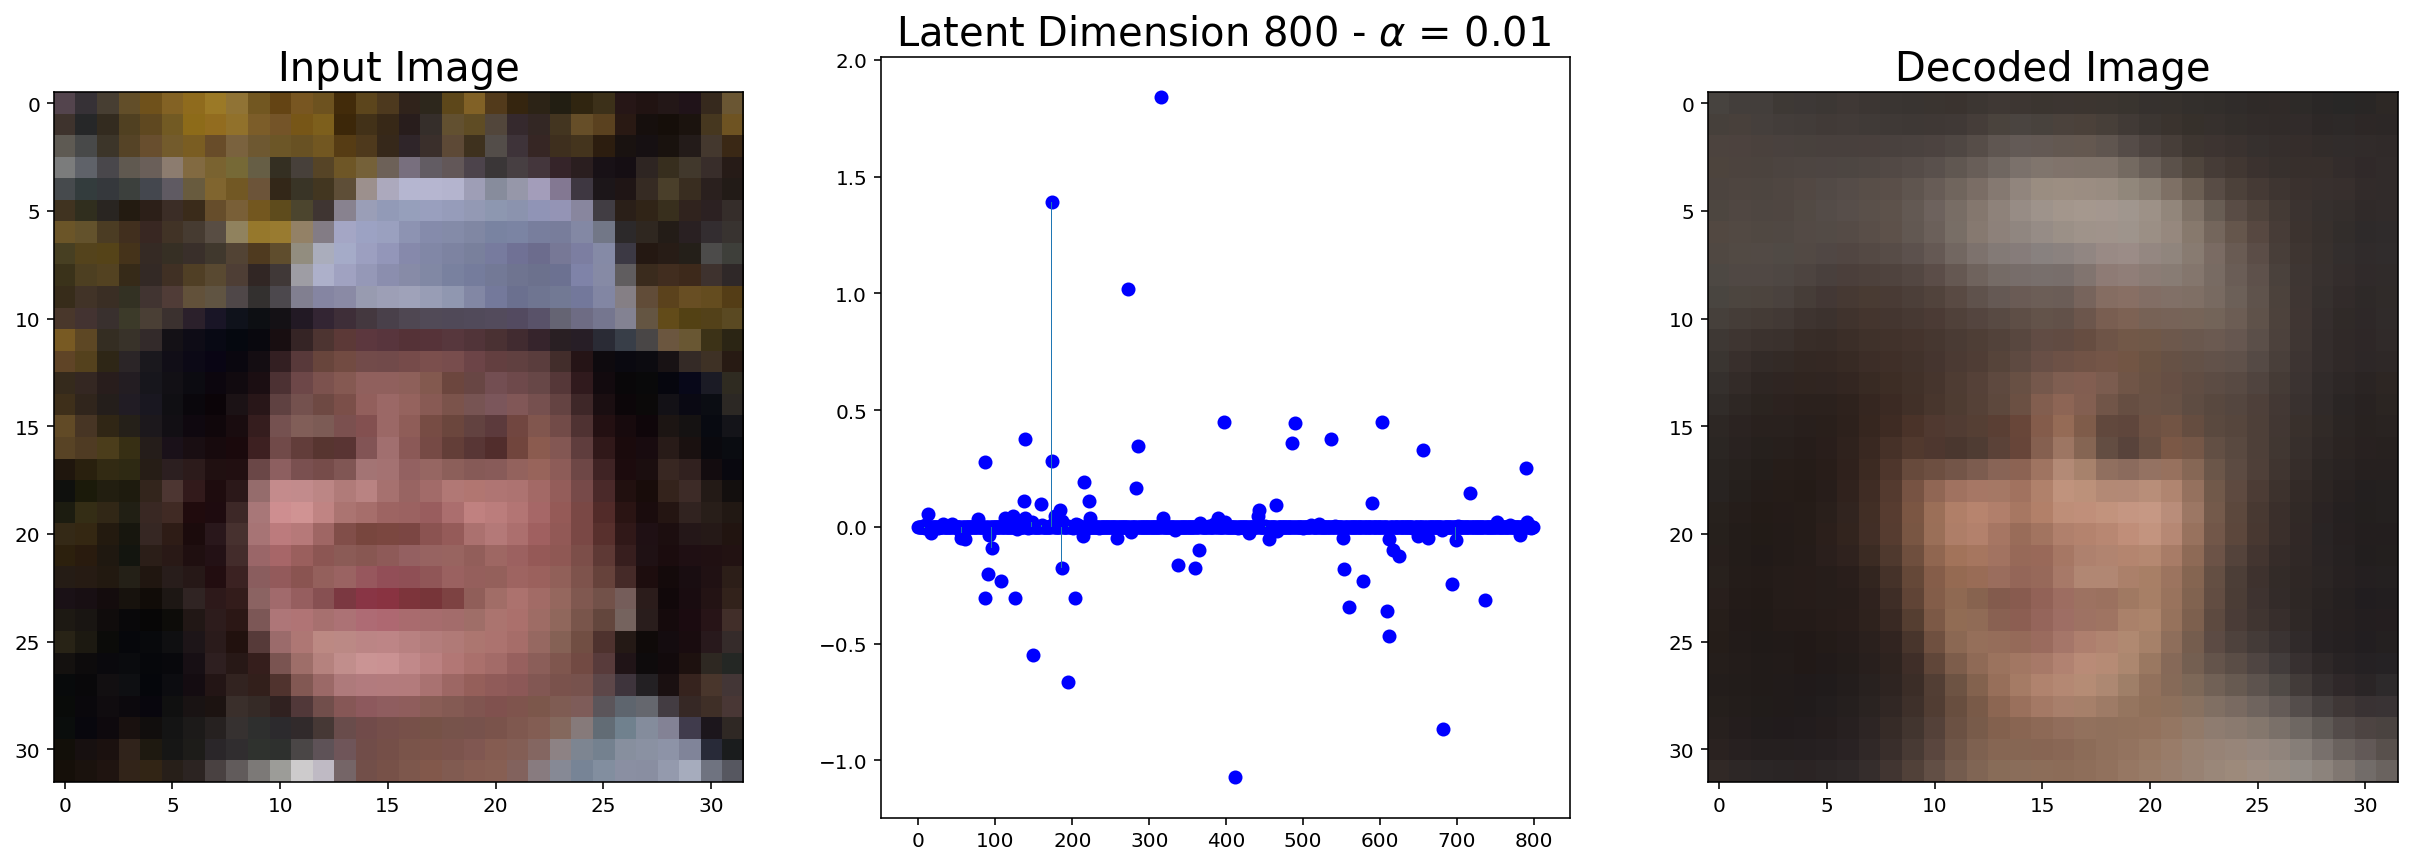

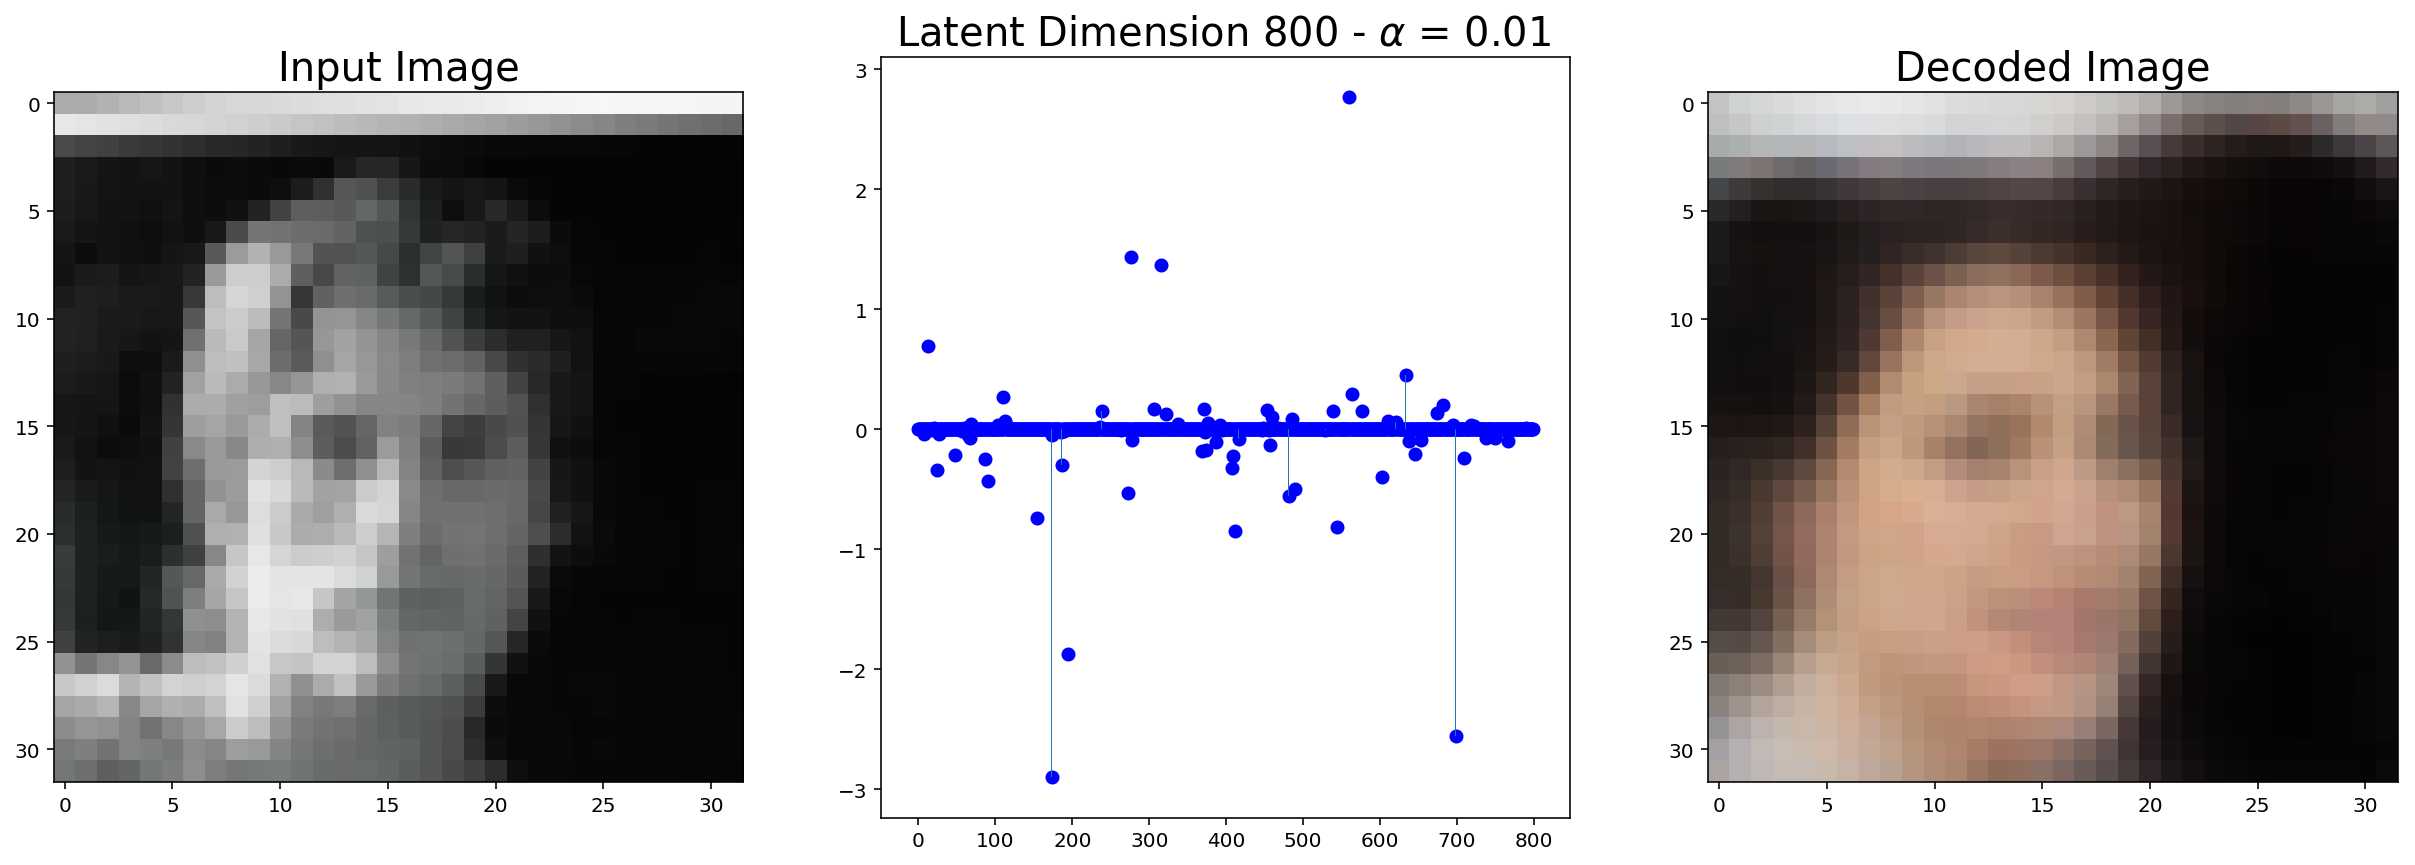

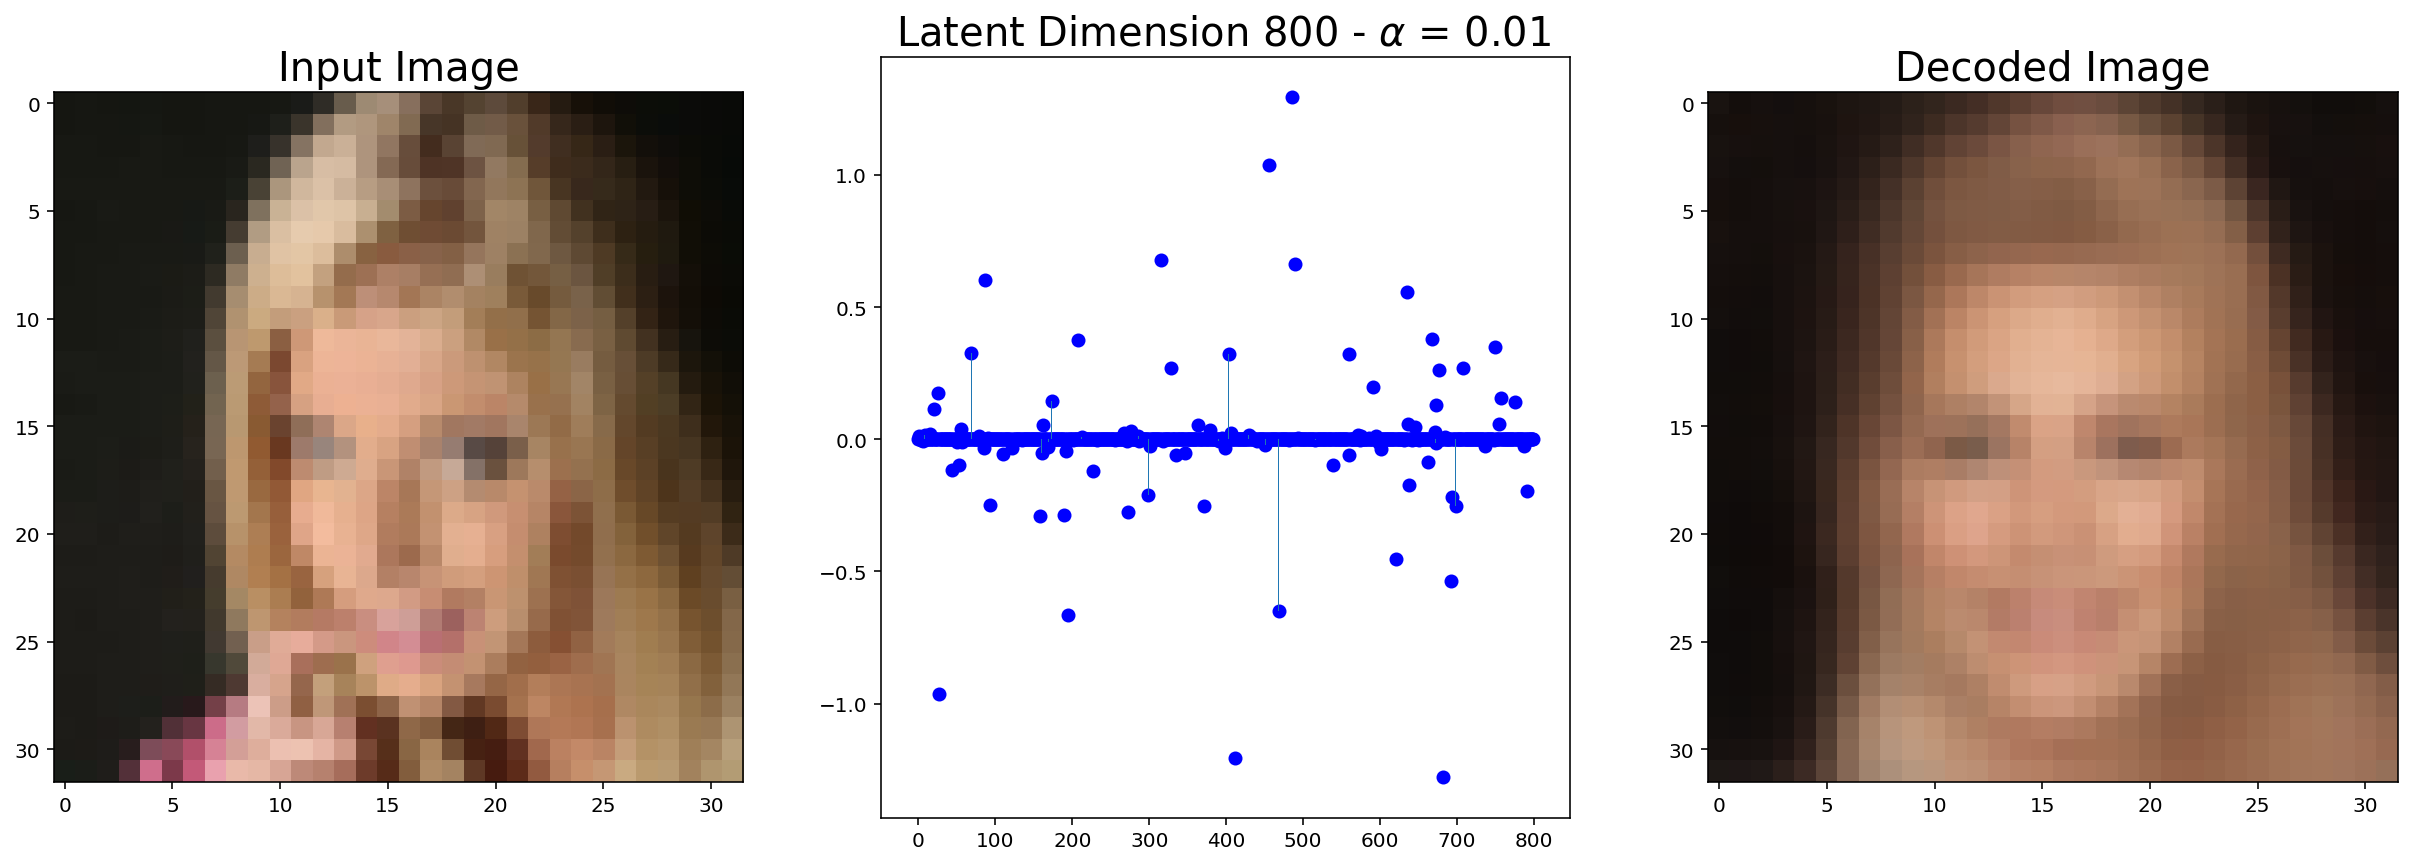

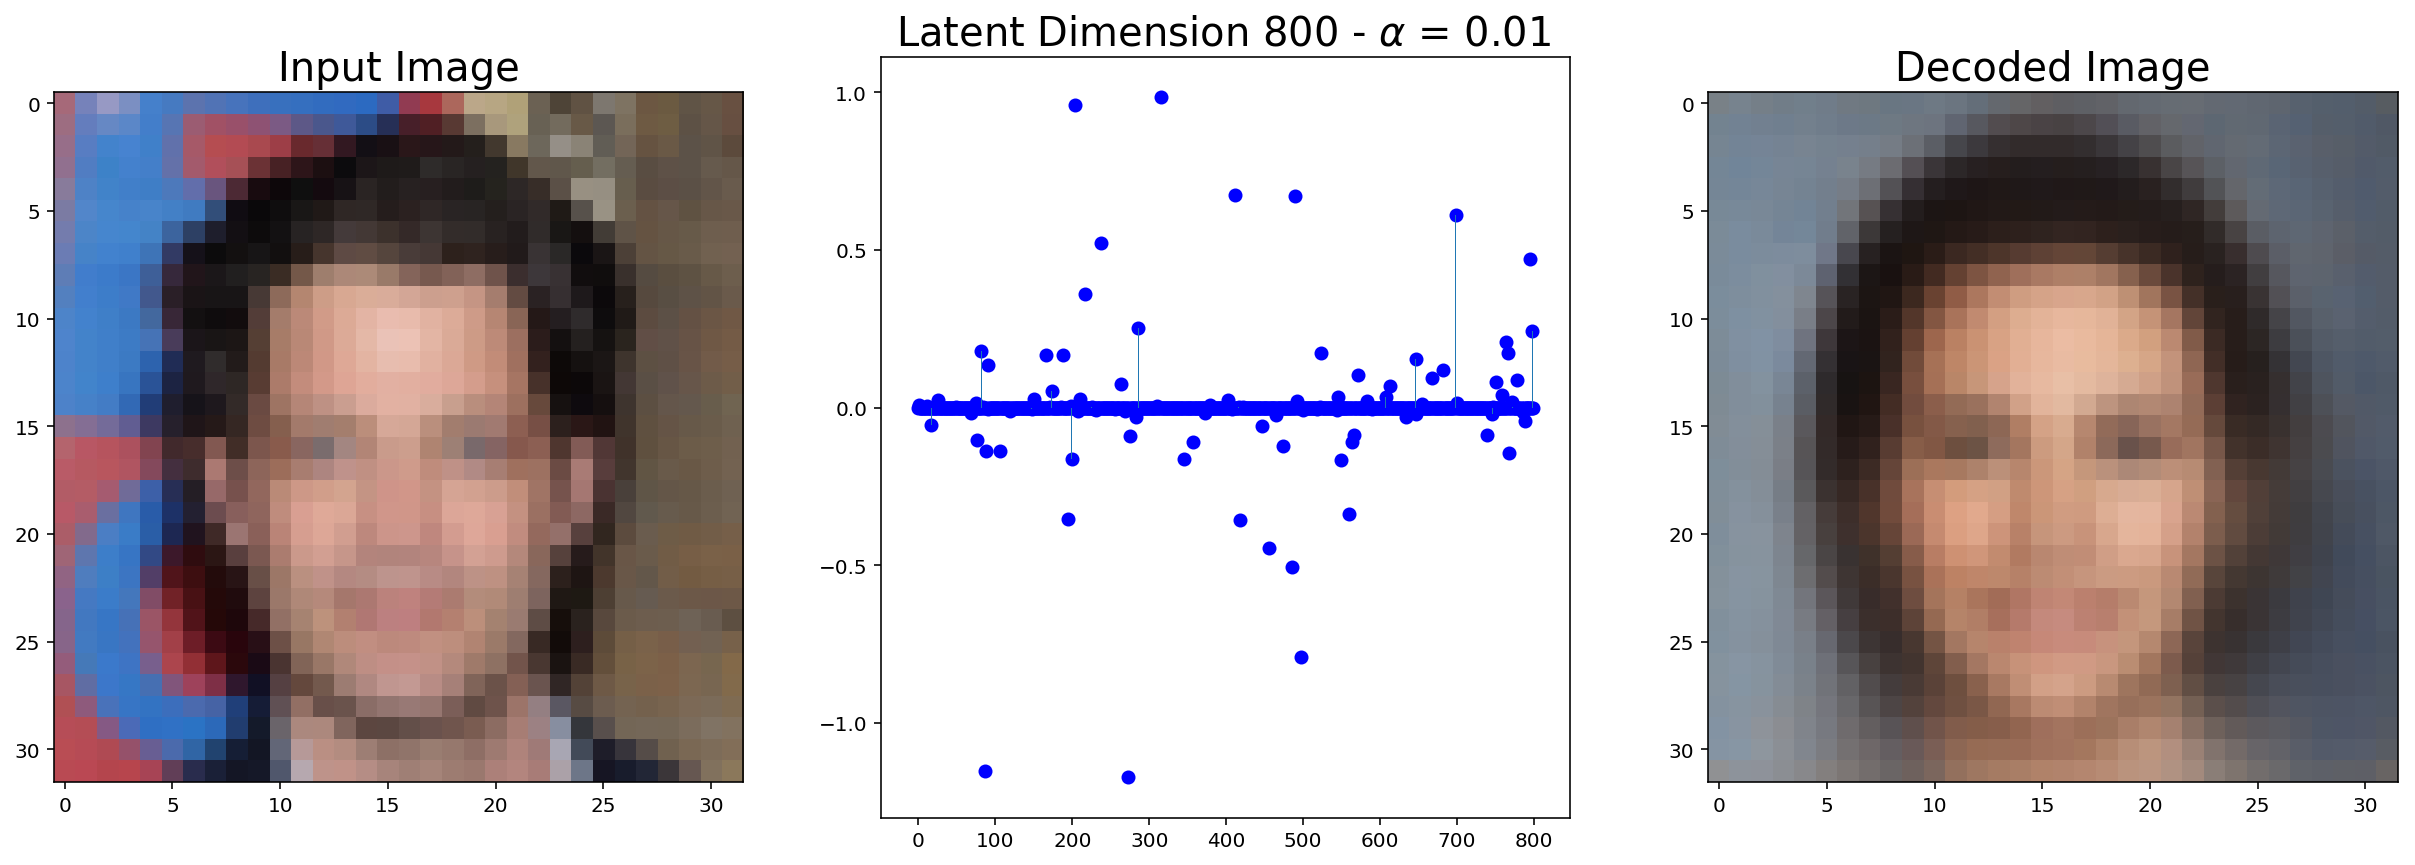

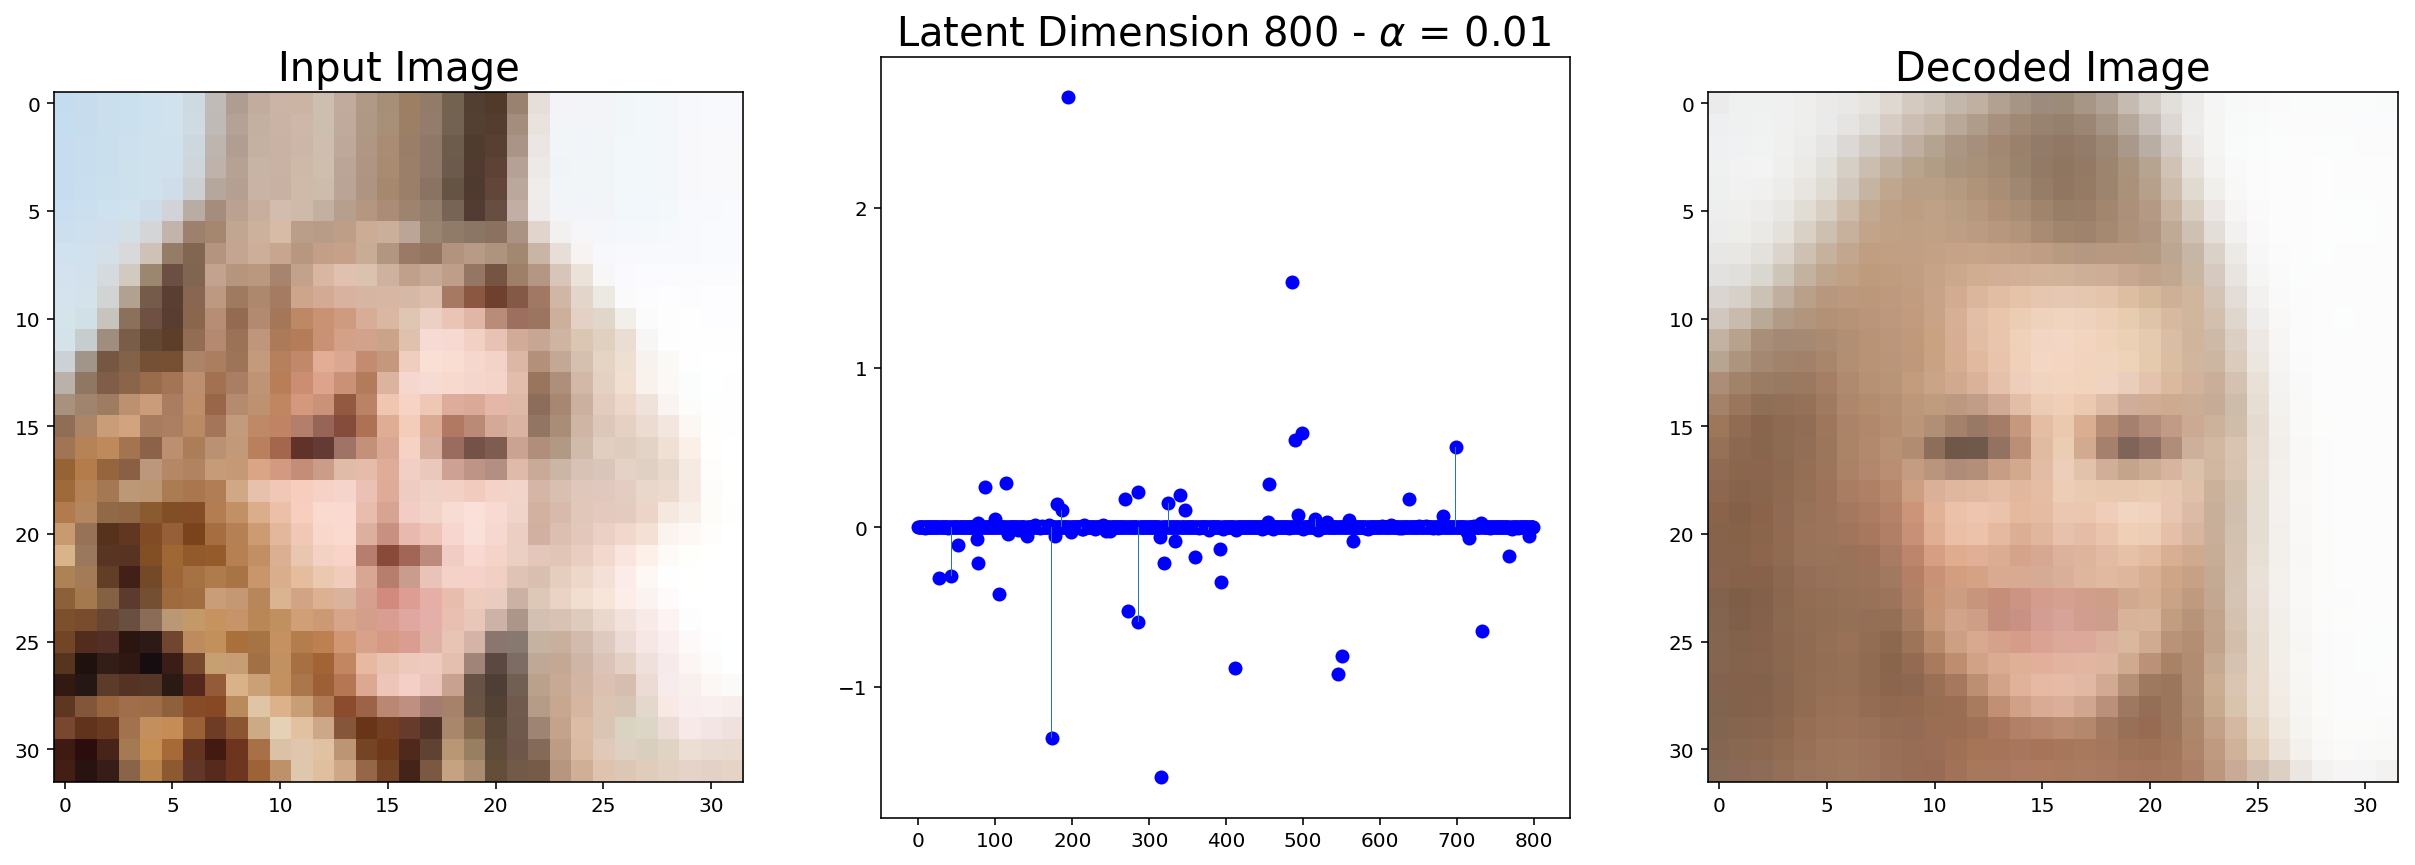

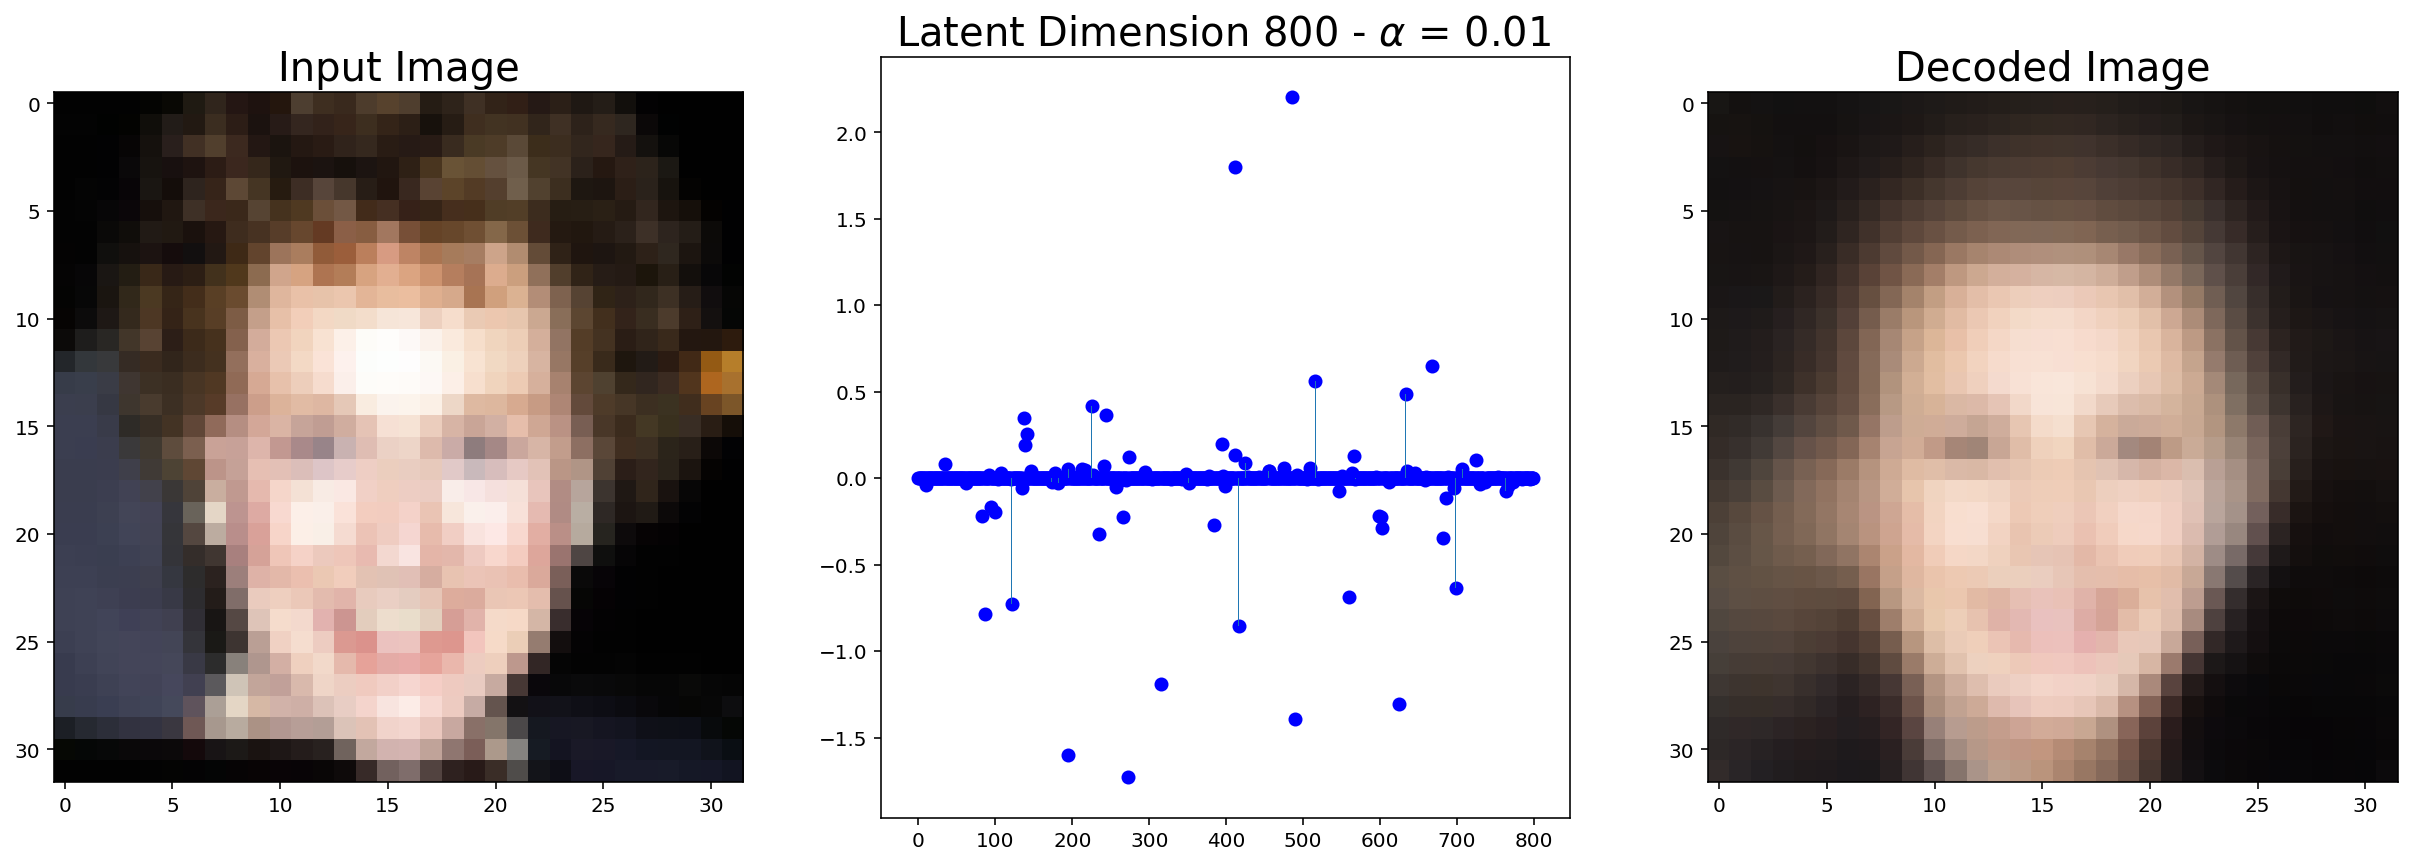

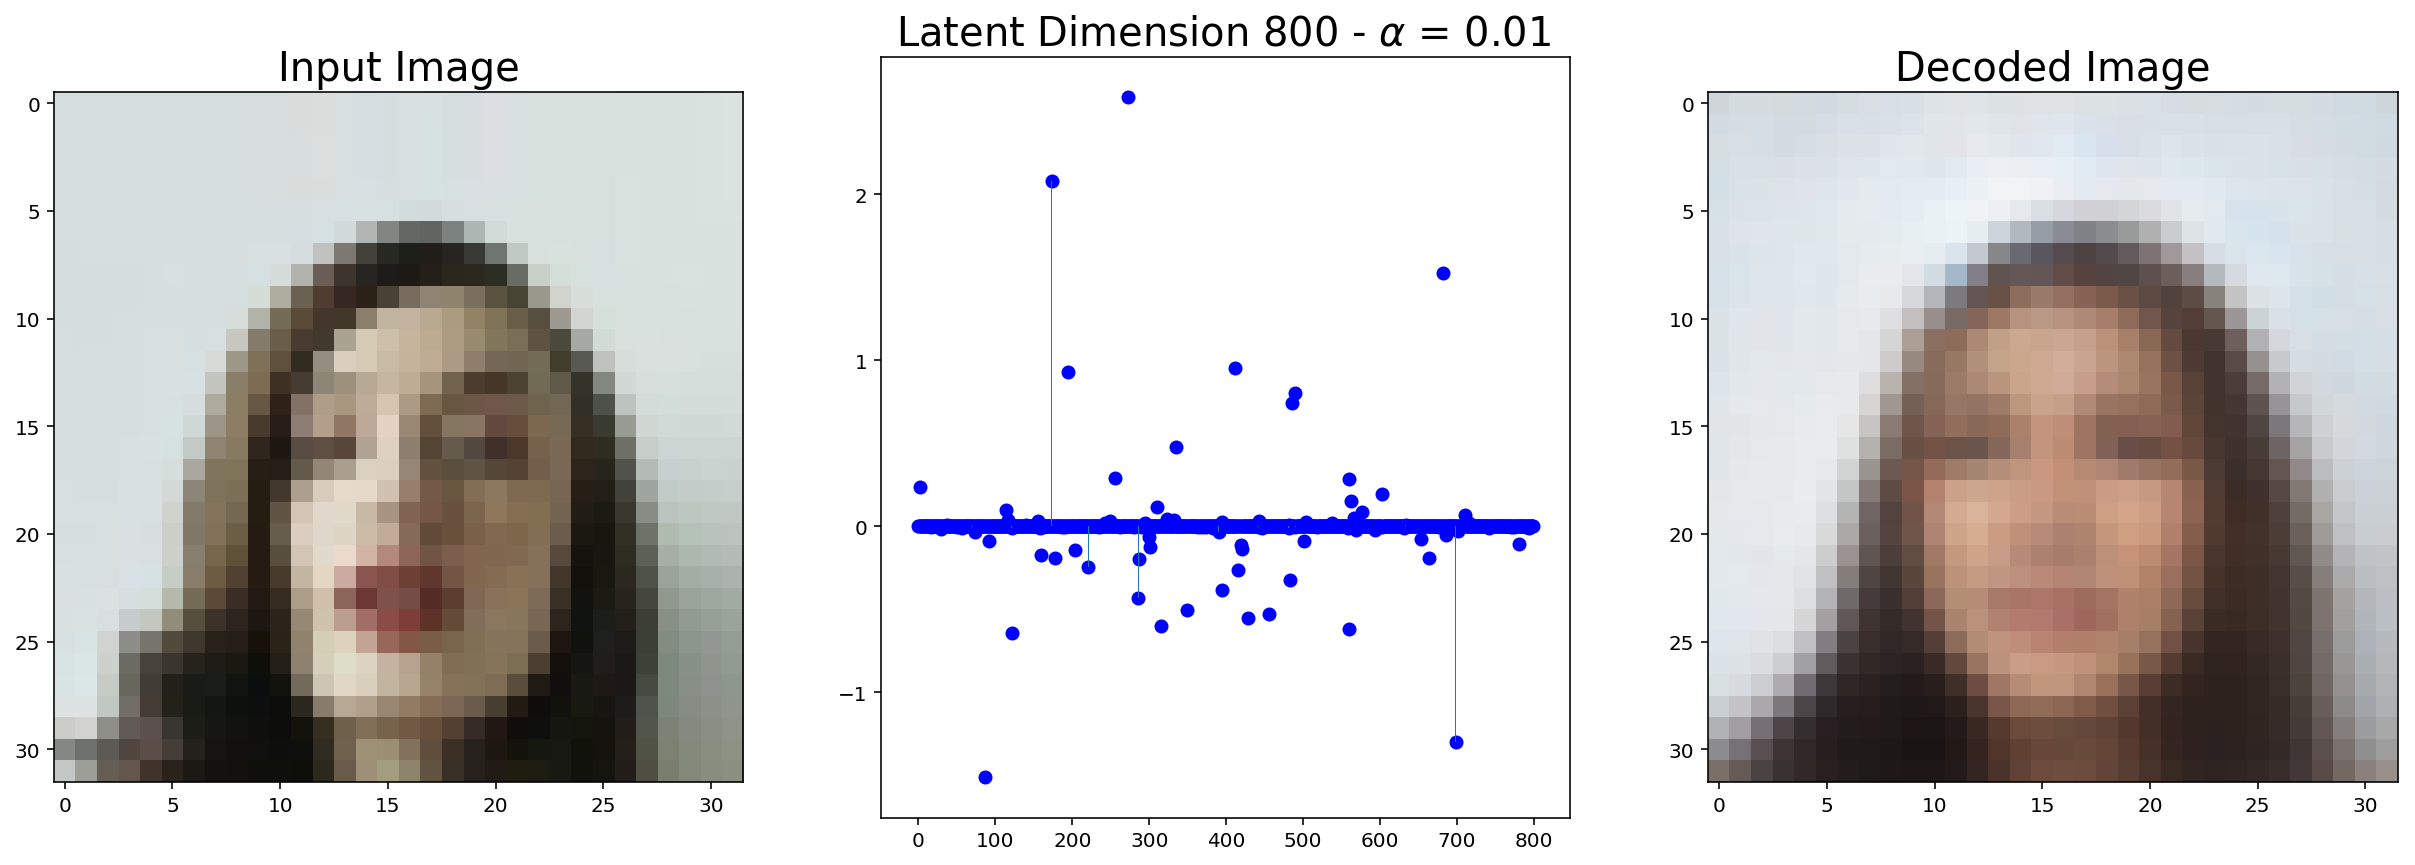

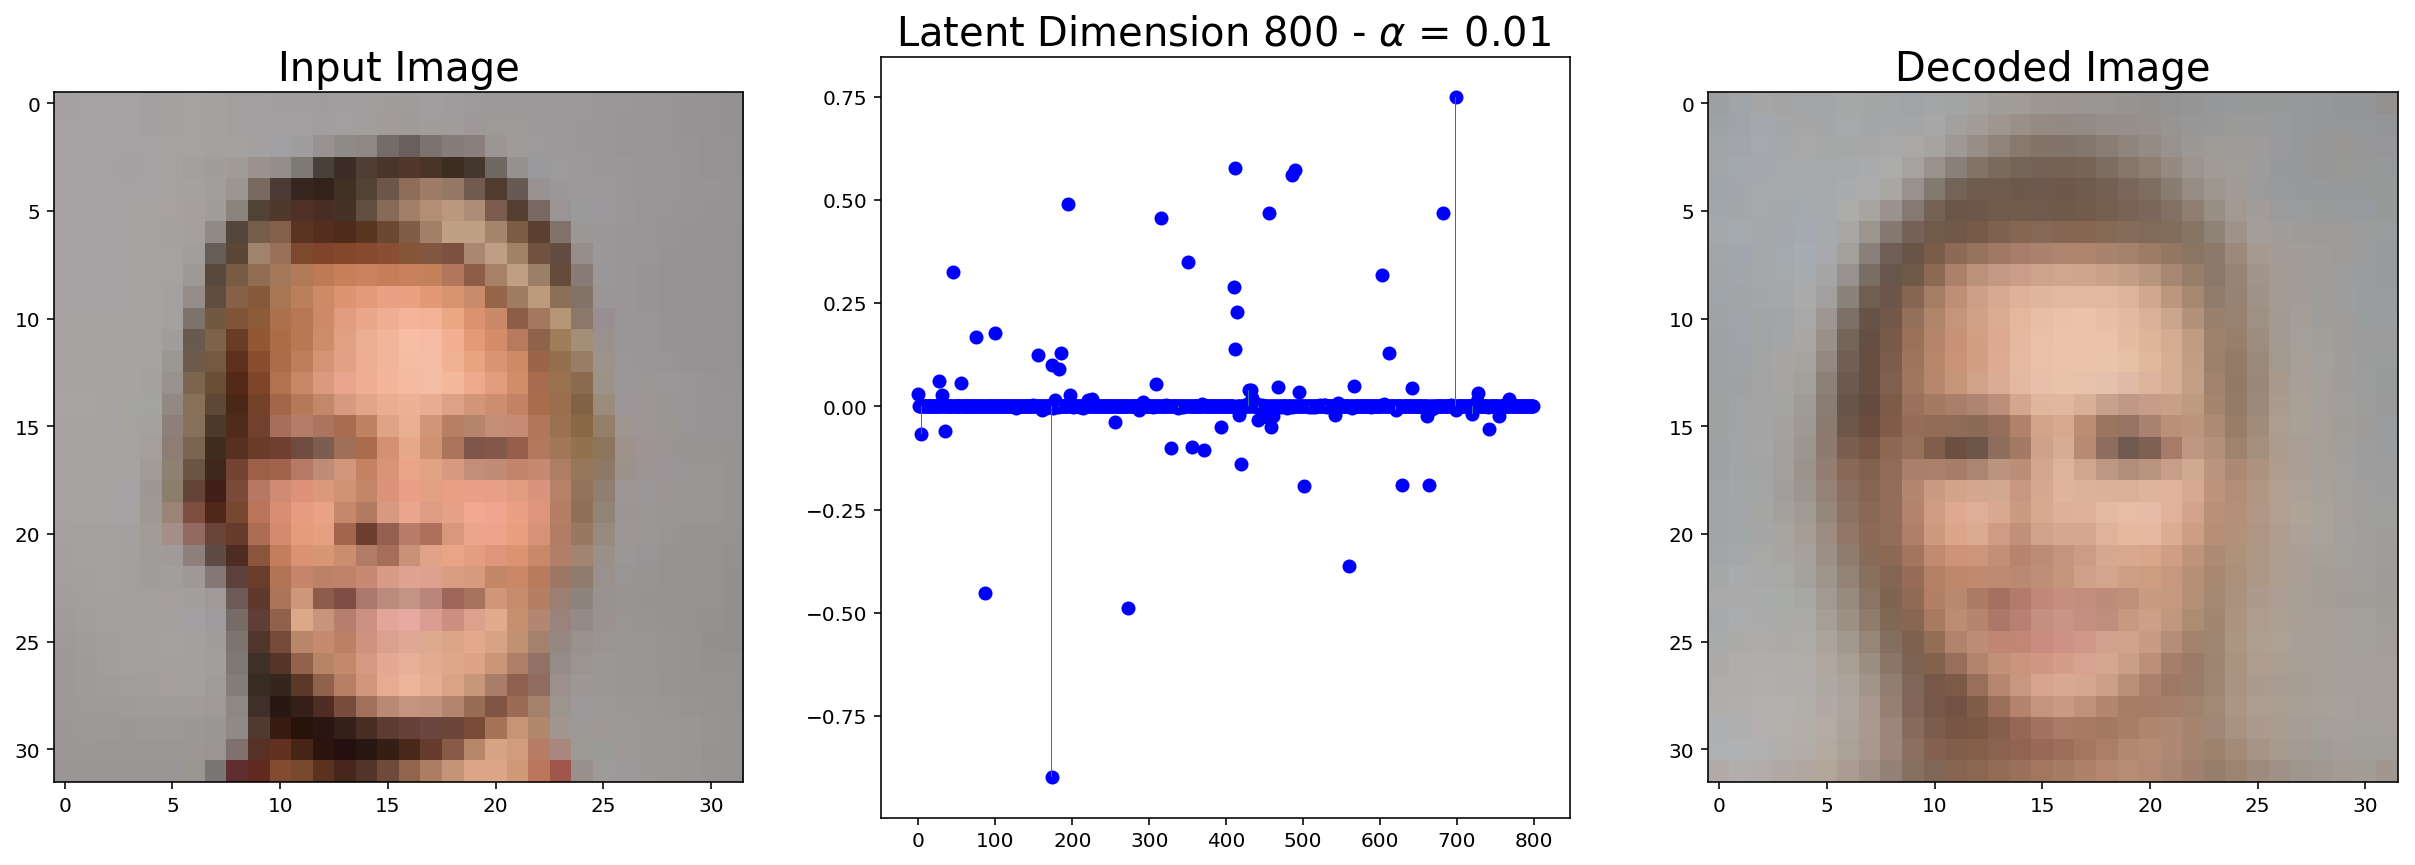

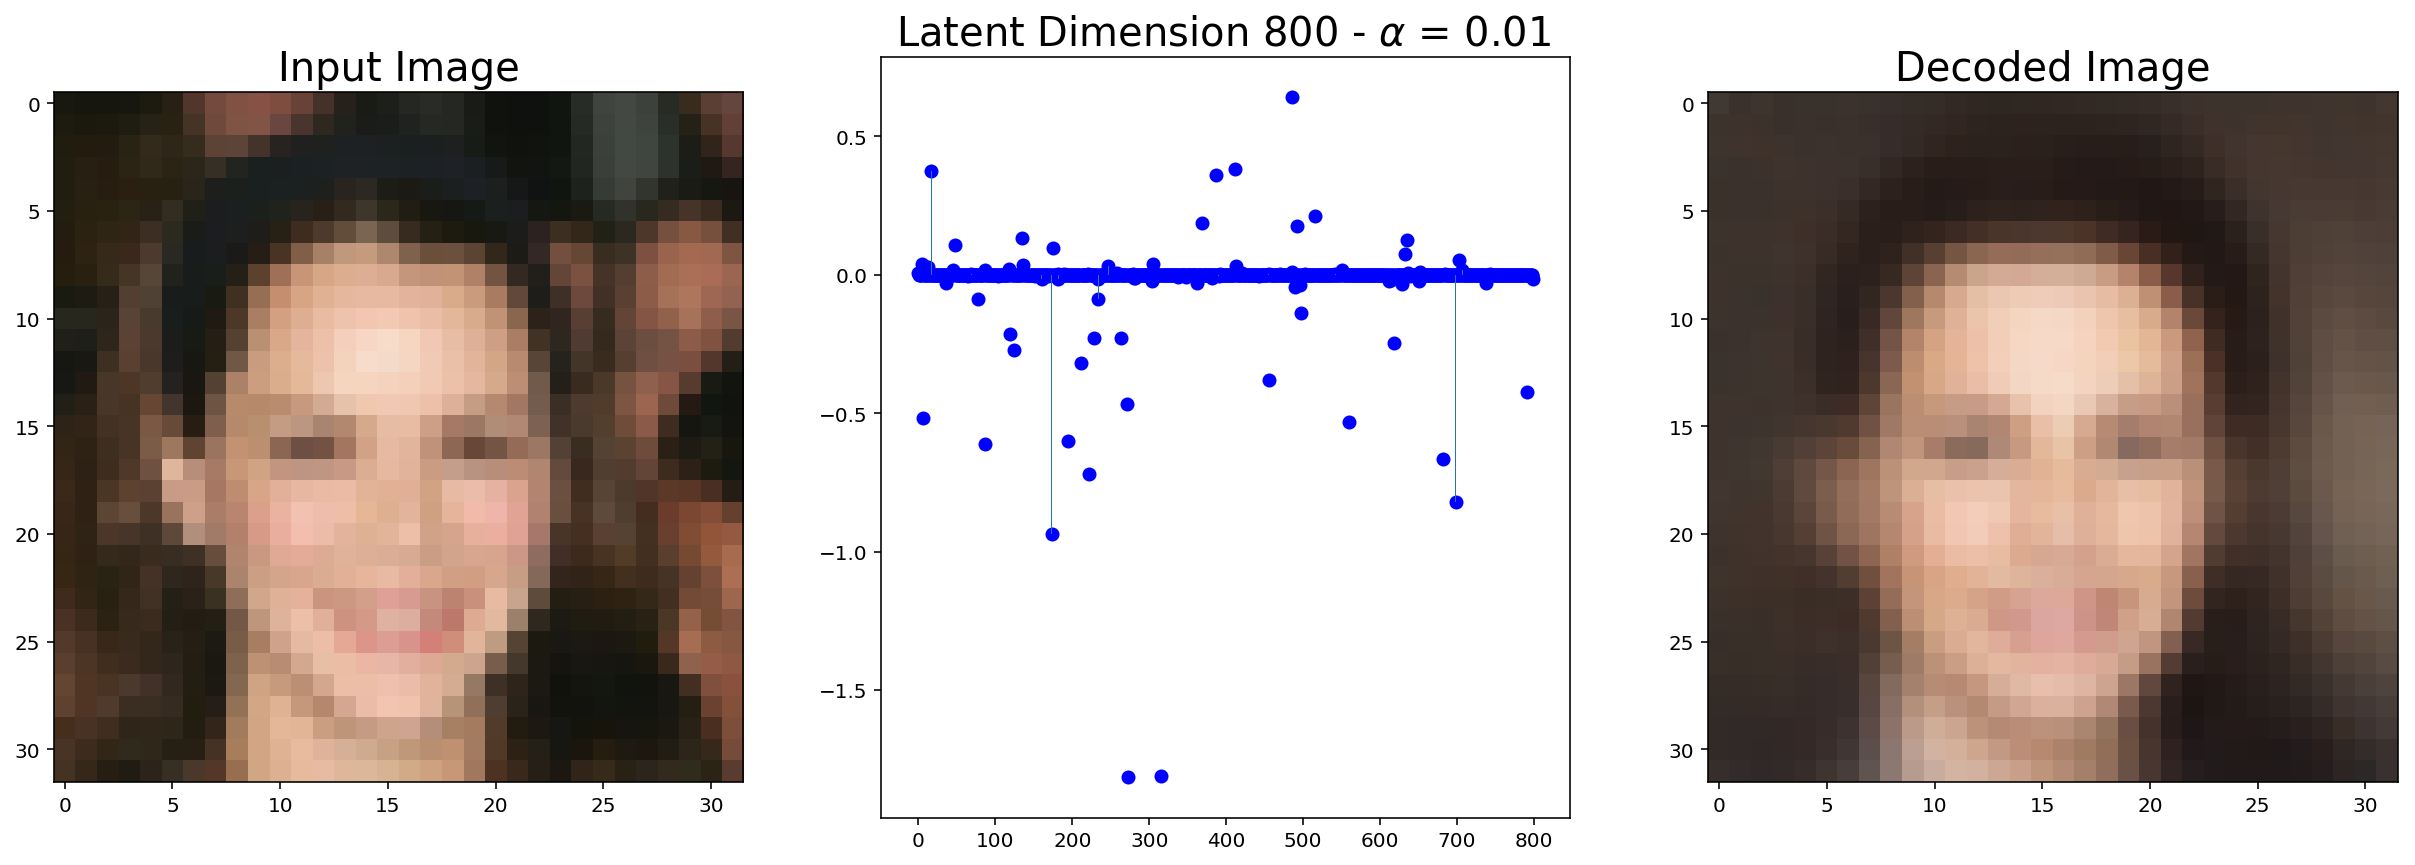

In [16]:
for i in range(10):
    plot_encoding(images[-i][None,:], convvsc, model_params['latent_sz'], 
                  model_params['alpha'])

In [23]:
import random

def plot_horizontal_traversal(image, vsc, latent_sz, length, 
                              delta, threshold=1e-4, plot_all=False, 
                              plot_list=None, width=1/4):
    flattened_image = vsc.transform(image).to(vsc.device)
    decoded, mu, logvar, logspike = vsc.model.forward(flattened_image)
    z = vsc.model.reparameterize(mu, logvar, logspike)
    img = vsc.inverse_transform(vsc.model.decode(z))
    z_ = z.cpu().detach().numpy()[0]
    
    plt.bar(np.arange(latent_sz), height=z_, width=width, align='center')
    plt.scatter(np.arange(latent_sz), z_, color='blue')
    plt.show()
    
    non_zero = [i for i in range(latent_sz) if np.abs(z_[i]) > threshold]
    ind = random.choice(non_zero)
    print(ind, non_zero)
    
    if not plot_all:
        non_zero = [ind]
    if plot_list:
        non_zero = plot_list
    
    hor_traversal = []
    for ind in non_zero:
        images = []
        z1 = z.clone()
        for i in range(length):
            img = to_numpy(vsc.model.decode(z1), vsc)
            images.append(np.transpose(img, (1,2,0)))
            z1[0, ind] = z1[0, ind] + delta if z[0,ind] < 0 else z1[0, ind] - delta

        hor_traversal.append(np.concatenate(images, axis=1))
    traversal = np.concatenate(hor_traversal, axis=0)
    plt.figure(figsize=(15,15))
    plt.axis('off')
    plt.imshow(traversal)
    plt.show()
#     return traversal

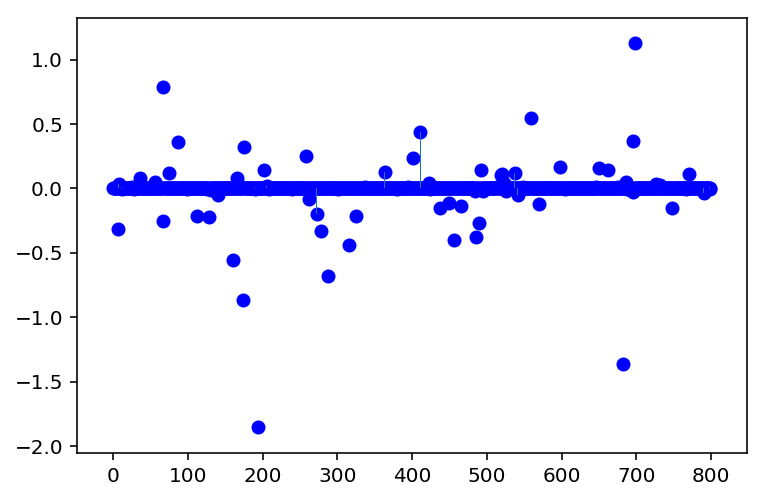

559 [6, 67, 86, 160, 173, 175, 194, 278, 287, 315, 411, 456, 485, 559, 682, 695, 698]


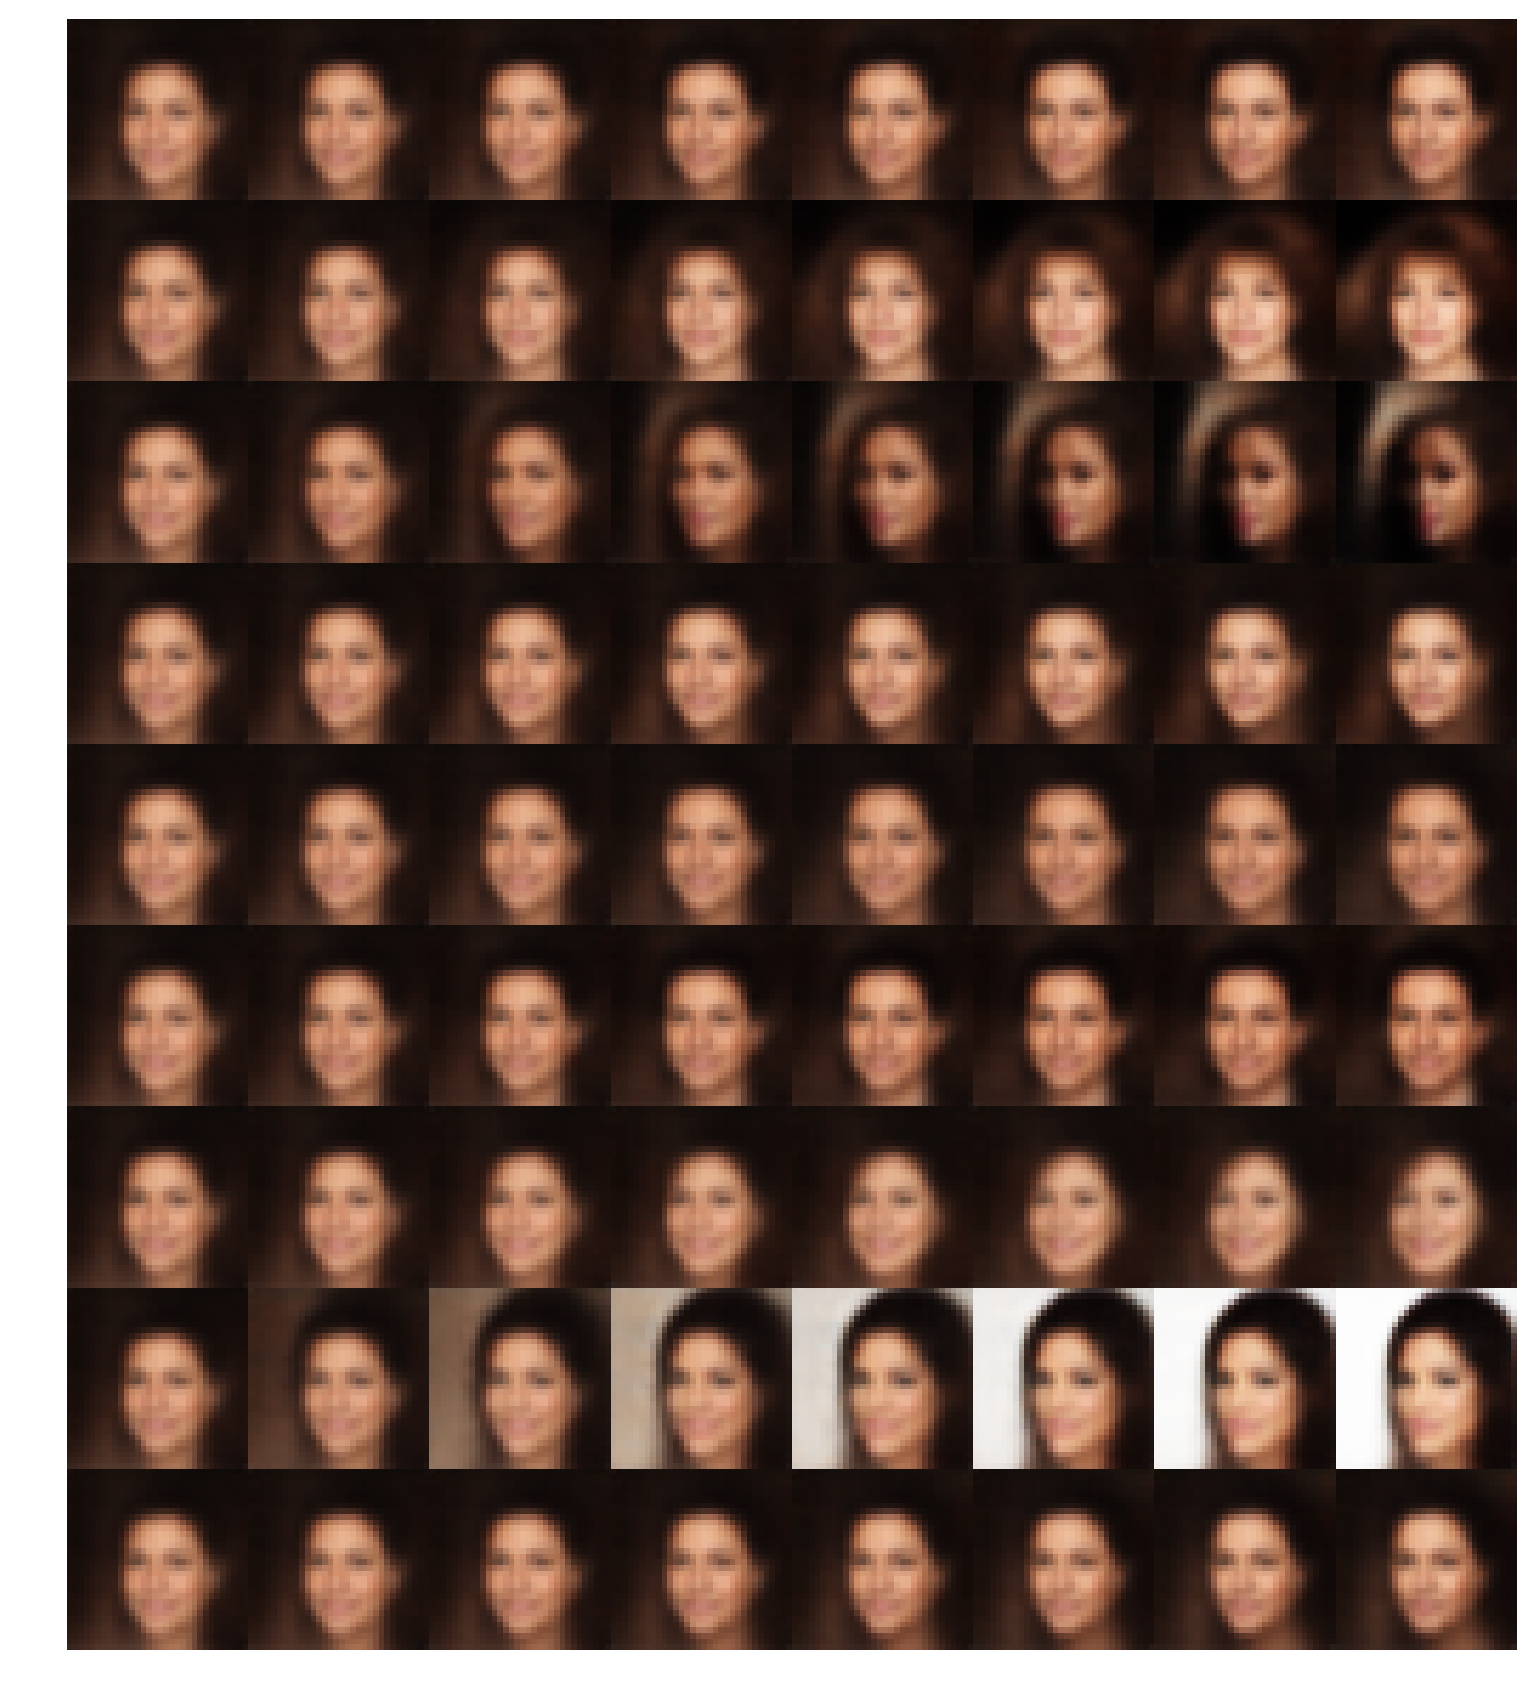

In [33]:
plot_horizontal_traversal(images[8][None,:], convvsc, 
                          model_params['latent_sz'], length=8, 
                          delta=0.8, threshold=3e-1,
                          plot_all=False, 
                          plot_list=[61, 173, 272, 339, 482, 498, 
                                     669, 682, 721])

In [ ]:
final = [plot_horizontal_traversal(images[idx][None,:], vsc, latent_size, 
                                alpha, length=8, delta=d, threshold=3e-1,
                                plot_all=False, plot_list=[dim]) \
         for idx, d, dim in [
    (3, 0.28, 370),
    (7, 0.28, 308),
#     (9, 0.38, 437),
#     (11, 0.32, 370),
#     (13, 0.2, 770),
#     (14, 0.3, 770),
    (16, 0.5, 398),
    (17, 0.4, 370),
    (18, 0.38, 308),
#     (19, 0.34, 398),
    (20, 0.3, 770),
#     (22, 0.3, 770),
    (28, 0.4, 724),
    (30, 0.42, 770),
    (31, 0.4, 102)
]]